# 0 Project Setup

## 0.1 Task

* Use the dataset to create a graph, where movies are linked to each other based on the common / similar features. You are free to choose which features to use and how.
  * For example, you could link two movies if they share the same genre. However, if that is your only type of link, movies will only be similar to movies with the same genre.

* Pick a movie you know and make a number of movie recommendations:
  * Your recommendations should follow the same logic you can observe on Netflix or other streaming services: if a user enjoyed the movie, they will most probably enjoy the ones you recommend too.
  * Your recommendations should be based on graph theory concepts and methods (centrality measures, predictions etc). Feel free to use the ones covered in the course or/and some others.
  * Feel free to test several approaches and compare the results.
  * Since there is no way of testing your recommendations’ precision, focus on the movies you know and see if the recommendations obtained with graph theory sound reasonable to you.
  * Generate recommendations for several movies, ideally those of different genres, eras, etc, to see how reliable your results are.

## 0.2 Dataset

The dataframe contains a list of movies and TV shows available on Netflix as well as all relevant information. If it rings a bell, you’re probably correct - we used this popular dataframe on a few occasions during this course. The following features are available:

field | meaning | weight | usage
--- | --- | --- | ---
show_id 1 | Unique ID for every Movie / TV Show | -- | short string to label plots
type | Identifier - A Movie or TV Show | 5 | similarity criteria
title | Title of the Movie / TV Show | -- | clear name to check results / can we identify sequels? / is it worth it or will other criteria provide the same information (e.g. cast)
director | director of the movie | 3 | similarity criteria
cast | Actors involved in the movie / show | 7 | similarity criteria / one hot encoding? count identical actors pairwise?
country | Country where the movie / show was produced | 3 | similarity criteria
date_added | Date it was added on Netflix | -- | not usefull, is it?
release_year | Actual Release year of the move / show | 1 | similarity criteria / maybe cluster or datediff(year) < 5 years
rating | TV Rating of the movie / show ("Altersfreigabe") | 3 | similarity criteria
listed_in | Category | 4 | similarity
duration | Total Duration - in minutes or number of seasons | 2 | maybe use clusters to distinguish between "epic films", "short films", "classical 90min",...

For the sake of simplicity, we will refer to both movies and TV shows as ‘movies’ in the task description below.


In [1]:
das ist ein feh


SyntaxError: invalid syntax (<ipython-input-1-2dc360bfa85a>, line 1)

## 0.3 Team

Christoph, Daniel, Simon

In [22]:
dshflöa %killbgscripts


NameError: name 'dshflöa' is not defined

---
# 1 Define Globals

In [7]:
import numpy as np, pandas as pd, networkx as nx
import matplotlib.pyplot as plt; from matplotlib.patheffects import withStroke
from time import time; from random import sample; from itertools import combinations
#from google.colab import drive; drive.mount('/content/drive')

#path_folder = '/content/drive/My Drive/Colab Notebooks/Woche 16 - Projekt/'
path_folder = ''
# https://drive.google.com/drive/folders/1cExGEHi3rC-lZNpVFhOk64UydO6YCWpG?usp=sharing
path_data_csv       = path_folder + 'netflix_titles.csv'
path_graph_pickle   = path_folder + 'netflix_graph.final.pickle.gz'
path_weights_pickle = path_folder + 'netflix_weights.final.pickle.gz'

## 1.1 Define feature weights

In [8]:
# define weight for all features used to create edges in the graph

weight_factors = dict(type=2, director=3, cast=10, country=3, release_year=2, rating=3, duration=5, listed_in=5)
weight_caps = dict(cast=2, country=2)

def log_config():
  print('# weight_factors:', *sorted(weight_factors.items(), key=lambda kv: -kv[1]), sep='\n')
  print('SUM of factors = maximum total weight:', sum(weight_factors.values()))

  print('\n# weight_caps:',
    '# Note: if not specified here, length_cap defaults to 1!',
    *weight_caps.items(), '', sep='\n')
log_config()

weight_columns = ['weight', *['weight_'+_ for _ in weight_factors]]
print('# weight_columns:', *weight_columns, sep='\n* ')

# weight_factors:
('cast', 10)
('duration', 5)
('listed_in', 5)
('director', 3)
('country', 3)
('rating', 3)
('type', 2)
('release_year', 2)
SUM of factors = maximum total weight: 33

# weight_caps:
# Note: if not specified here, length_cap defaults to 1!
('cast', 2)
('country', 2)

# weight_columns:
* weight
* weight_type
* weight_director
* weight_cast
* weight_country
* weight_release_year
* weight_rating
* weight_duration
* weight_listed_in


## 1.2 DataFrame info

In [9]:
def my_info(dataFrame, showMinMax=False):
  dataFrame = dataFrame.copy().reset_index(); from pandas import option_context
  info = dataFrame.dtypes.to_frame('DType')
  info['Null'] = dataFrame.isna().sum().transform(lambda n:
    f'{n} ({n / len(dataFrame) * 100 :6.1f} %)'.replace(' ', '\xA0'*2))
  for idx in info.index:
    if (type(dataFrame[idx].iat[0]) not in [list, set]): series_tmp = dataFrame[idx]
    else: series_tmp = dataFrame[idx].apply(lambda series: tuple(series))
    info.at[idx, 'nUnique'] = str(series_tmp.nunique(dropna=False))
    try: uniques = series_tmp.unique(); uniques.sort()
    except: uniques = sorted(uniques, key=repr)
    info.at[idx, f'Uniques [{len(dataFrame)} rows total]'] = str(uniques).replace('\n','')
    info.at[idx, 'Top_5'] = str(series_tmp.value_counts(dropna=False).head().to_dict())
  if (showMinMax): info['Min'] = dataFrame.min(); info['Max'] = dataFrame.max(); \
    info['Median'] = dataFrame.median(); info['Mean'] = dataFrame.mean(); \
    info['Variance'] = dataFrame.var(); info['StdDev'] = dataFrame.std()
  with option_context('max_colwidth', 275): display(info.rename_axis('Column').reset_index())
  dtypes = str(sorted(info['DType'].value_counts(sort=False).to_string().split('\n')))
  while '  ' in dtypes: dtypes = dtypes.replace('  ', ' ')
  print('DTypes: ' + dtypes[2:-2].replace(' ','(').replace("',('",'), ') + ')')

## 1.3 Cluster duration values

In [10]:
def func_dur(row):
  if (row['type'] != 'Movie'): return 'TV Show'
  try: dur = int(row['duration'].replace(' min', ''))
  except: return row['duration']
  if (dur <  30): return 'Short'
  if (dur <  85): return 'Episode'
  if (dur < 120): return 'Movie'
  return 'Epic' # (dur >= 120)

---
# 2 Import Data

In [12]:
# load data, remove useless column, set index on ID)
df_netflix = pd.read_csv(path_data_csv, index_col='show_id').drop(columns='date_added')
df_netflix

,type,title,director,cast,country,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,
81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...
80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...


In [13]:
my_info(df_netflix)

,Column,DType,Null,nUnique,Uniques [6234 rows total],Top_5
0,show_id,int64,0 ( 0.0 %),6234,[ 247747 269880 281550 ... 81228864 81235603 81235729],"{80218111: 1, 81010662: 1, 80188051: 1, 70077076: 1, 80192149: 1}"
1,type,object,0 ( 0.0 %),2,['Movie' 'TV Show'],"{'Movie': 4265, 'TV Show': 1969}"
2,title,object,0 ( 0.0 %),6172,['#Roxy' '#Rucker50' '#Selfie' ... '마녀사냥' '반드시 잡는다' '최강전사 미니특공대 : 영웅의 탄생'],"{'Oh My Ghost': 3, 'Love': 3, 'Tunnel': 3, 'The Silence': 3, 'Limitless': 3}"
3,director,object,1969 ( 31.6 %),3302,"[""Alma Har'el"", ""André D'Elia"", ""Anthony D'Souza"", ""Bill D'Elia"", ""Brian O'Malley"", ""Federico D'Alessandro"", ""Gavin O'Connor"", ""Jasmine D'Souza"", ""Liam O'Donnell"", ""Mark O'Connor"", ""Matt D'Avella"", ""Meghan O'Hara"", ""Pablo D'Alo Abba"", ""Remo D'Souza"", ""Renzil D'Silva"", ""R...","{nan: 1969, 'Raúl Campos, Jan Suter': 18, 'Marcus Raboy': 14, 'Jay Karas': 13, 'Jay Chapman': 12}"
4,cast,object,570 ( 9.1 %),5470,"[""Abhay Deol, Mahie Gill, Kalki Koechlin, Sindbad Phgura, Ammo 'Too Sweet', Jimi the Quiff, Parakh Madan"", ""Adam Scott, Evangeline Lilly, Bridget Everett, Owen Atlas, Chris D'Elia, Donald Faison, Clancy Brown, Tyler Labine, Kyle Bornheimer, Carla Gallo, Brad Williams, Sa...","{nan: 570, 'David Attenborough': 18, 'Samuel West': 10, 'Jeff Dunham': 7, 'Craig Sechler': 6}"
5,country,object,476 ( 7.6 %),555,"['Argentina', 'Argentina, Brazil, France, Poland, Germany, Denmark', 'Argentina, Chile', 'Argentina, Chile, Peru', 'Argentina, France', 'Argentina, France, Germany', 'Argentina, Italy', 'Argentina, Spain', 'Argentina, United States', 'Argentina, United States, Mexico', '...","{'United States': 2032, 'India': 777, nan: 476, 'United Kingdom': 348, 'Japan': 176}"
6,release_year,int64,0 ( 0.0 %),72,[1925 1942 1943 1944 1945 1946 1947 1954 1955 1956 1958 1959 1960 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 ...,"{2018: 1063, 2017: 959, 2019: 843, 2016: 830, 2015: 517}"
7,rating,object,10 ( 0.2 %),15,"['G', 'NC-17', 'NR', 'PG', 'PG-13', 'R', 'TV-14', 'TV-G', 'TV-MA', 'TV-PG', 'TV-Y', 'TV-Y7', 'TV-Y7-FV', 'UR', nan]","{'TV-MA': 2027, 'TV-14': 1698, 'TV-PG': 701, 'R': 508, 'PG-13': 286}"
8,duration,object,0 ( 0.0 %),201,['1 Season' '10 Seasons' '10 min' '100 min' '101 min' '102 min' '103 min' '104 min' '105 min' '106 min' '107 min' '108 min' '109 min' '11 Seasons' '11 min' '110 min' '111 min' '112 min' '113 min' '114 min' '115 min' '116 min' '117 min' '118 min' '119 min' '12 Seasons' '1...,"{'1 Season': 1321, '2 Seasons': 304, '3 Seasons': 158, '90 min': 111, '91 min': 104}"
9,listed_in,object,0 ( 0.0 %),461,"['Action & Adventure' 'Action & Adventure, Anime Features, Children & Family Movies' 'Action & Adventure, Anime Features, Classic Movies' 'Action & Adventure, Anime Features, Horror Movies' 'Action & Adventure, Anime Features, International Movies' 'Action & Adventure, A...","{'Documentaries': 299, 'Stand-Up Comedy': 273, 'Dramas, International Movies': 248, 'Dramas, Independent Movies, International Movies': 186, 'Comedies, Dramas, International Movies': 174}"


DTypes: int64(2), object(9)


## 2.1 Data preprocessing

In [14]:
# get Bruce Willis films before changing column to set instead of list
bruce_films = df_netflix.index[df_netflix.cast.fillna('').str.contains('Bruce Willis')]

print(len(bruce_films), 'films with Bruce Willis in the cast:')
df_netflix.loc[bruce_films].reset_index()

10 films with Bruce Willis in the cast:


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80187228,Movie,First Kill,Steven C. Miller,"Hayden Christensen, Bruce Willis, Gethin Antho...","United Kingdom, Canada, United States",2017,R,102 min,Action & Adventure,A stock broker brings his young son back to th...
1,70021630,Movie,Sin City,"Robert Rodriguez, Frank Miller","Bruce Willis, Mickey Rourke, Jessica Alba, Cli...",United States,2005,R,124 min,Action & Adventure,"In these intertwined tales, an ex-con avenges ..."
2,292118,Movie,Beavis and Butt-head Do America,Mike Judge,"Mike Judge, Bruce Willis, Demi Moore, Cloris L...",United States,1996,PG-13,81 min,"Comedies, Cult Movies","After realizing that their boob tube is gone, ..."
3,70044870,Movie,16 Blocks,Richard Donner,"Bruce Willis, Mos Def, David Morse, Jenna Ster...","United States, Germany",2006,PG-13,102 min,Action & Adventure,Tasked with escorting a prosecution witness to...
4,684847,Movie,The Last Boy Scout,Tony Scott,"Bruce Willis, Damon Wayans, Chelsea Field, Nob...",United States,1991,R,105 min,"Action & Adventure, Comedies",Private eye Joe Hallenbeck is forced to team u...
5,70199239,Movie,Set Up,Mike Gunther,"50 Cent, Ryan Phillippe, Bruce Willis, Rory Ma...",United States,2011,R,85 min,Action & Adventure,"A diamond heist goes horribly wrong, and the g..."
6,70058019,Movie,Perfect Stranger,James Foley,"Halle Berry, Bruce Willis, Giovanni Ribisi, Ri...",United States,2007,R,109 min,Thrillers,Ro risks her life to discover the identity of ...
7,880640,Movie,Pulp Fiction,Quentin Tarantino,"John Travolta, Samuel L. Jackson, Uma Thurman,...",United States,1994,R,154 min,"Classic Movies, Cult Movies, Dramas",This stylized crime caper weaves together stor...
8,60026139,Movie,Tears of the Sun,Antoine Fuqua,"Bruce Willis, Monica Bellucci, Cole Hauser, Ea...",United States,2003,R,121 min,"Action & Adventure, Dramas",A Navy SEAL is sent to a war-torn African jung...
9,80013712,Movie,The Prince,Brian A. Miller,"Jason Patric, Bruce Willis, John Cusack, Rain,...","United States, United Kingdom",2014,R,91 min,Action & Adventure,A former Mafia hit man living quietly as a mec...


In [15]:
# also, get some Robert De Niro films ;-)
deniro_films = df_netflix.index[df_netflix.cast.fillna('').str.contains('Robert De Niro')]

print(len(deniro_films), 'films with Robert De Niro in the cast:')
df_netflix.loc[deniro_films].reset_index()

9 films with Robert De Niro in the cast:


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,70020699,Movie,Raging Bull,Martin Scorsese,"Robert De Niro, Cathy Moriarty, Joe Pesci, Fra...",United States,1980,R,129 min,"Classic Movies, Dramas, Sports Movies",This gritty biopic of brutal boxer Jake LaMott...
1,60020826,Movie,The Score,Frank Oz,"Robert De Niro, Edward Norton, Marlon Brando, ...","Germany, Canada, United States",2001,R,124 min,"Dramas, Thrillers","Ready-to-retire safecracker Nick, flamboyant f..."
2,80175798,Movie,The Irishman,Martin Scorsese,"Robert De Niro, Al Pacino, Joe Pesci, Harvey K...",United States,2019,R,209 min,Dramas,Hit man Frank Sheeran looks back at the secret...
3,70142827,Movie,Limitless,Neil Burger,"Bradley Cooper, Abbie Cornish, Robert De Niro,...",United States,2011,PG-13,105 min,"Action & Adventure, Sci-Fi & Fantasy, Thrillers","With his writing career dragging, Eddie Morra ..."
4,70098605,Movie,Righteous Kill,Jon Avnet,"Robert De Niro, Al Pacino, 50 Cent, Carla Gugi...",United States,2008,R,101 min,"Dramas, Thrillers",Two detectives investigate a rash of vigilante...
5,70001958,Movie,Mean Streets,Martin Scorsese,"Robert De Niro, Harvey Keitel, David Proval, A...",United States,1973,R,112 min,"Classic Movies, Dramas, Independent Movies","In New York's Little Italy, a low-level hoodlu..."
6,18907685,Movie,Taxi Driver,Martin Scorsese,"Robert De Niro, Jodie Foster, Cybill Shepherd,...",United States,1976,R,114 min,"Classic Movies, Dramas, Thrillers",Enraged by New York's moral rot and urban deca...
7,81212801,Movie,The Irishman: In Conversation,NaN,"Martin Scorsese, Robert De Niro, Al Pacino, Jo...",United States,2019,TV-MA,24 min,Documentaries,Join director Martin Scorsese as he sits down ...
8,60010514,Movie,Jackie Brown,Quentin Tarantino,"Pam Grier, Samuel L. Jackson, Robert Forster, ...",United States,1997,R,154 min,"Dramas, Thrillers",When an aging flight attendant's caught smuggl...


In [16]:
if (df_netflix['duration'].dtype == object):
  print(f'Computing categoricals of [duration] column...')
  df_netflix['type'] = df_netflix.apply(func_dur, axis='columns')
  df_netflix['duration'] = df_netflix['duration'].str.replace('\d+ Seasons?', '-1').str.replace(' min', '').astype(int)

# Convert some list-like columns to sets
for column in 'type director cast country rating listed_in'.split():
  if (type(df_netflix[column].iloc[0]) is not set):
    print(f'Converting column [{column}] to sets of data...')
    df_netflix[column] = df_netflix[column].fillna('').apply(lambda text: set() if text=='' else set(text.split(', ')))

my_info(df_netflix)

Computing categoricals of [duration] column...
Converting column [type] to sets of data...
Converting column [director] to sets of data...
Converting column [cast] to sets of data...
Converting column [country] to sets of data...
Converting column [rating] to sets of data...
Converting column [listed_in] to sets of data...


,Column,DType,Null,nUnique,Uniques [6234 rows total],Top_5
0,show_id,int64,0 ( 0.0 %),6234,[ 247747 269880 281550 ... 81228864 81235603 81235729],"{80218111: 1, 81010662: 1, 80188051: 1, 70077076: 1, 80192149: 1}"
1,type,object,0 ( 0.0 %),5,"[('Epic',) ('Episode',) ('Movie',) ('Short',) ('TV Show',)]","{('Movie',): 2405, ('TV Show',): 1969, ('Episode',): 924, ('Epic',): 859, ('Short',): 77}"
2,title,object,0 ( 0.0 %),6172,['#Roxy' '#Rucker50' '#Selfie' ... '마녀사냥' '반드시 잡는다' '최강전사 미니특공대 : 영웅의 탄생'],"{'Oh My Ghost': 3, 'Love': 3, 'Tunnel': 3, 'The Silence': 3, 'Limitless': 3}"
3,director,object,0 ( 0.0 %),3293,"[() ('A. L. Vijay',) ('A. Salaam',) ... ('Óskar Thór Axelsson',) ('Ömer Faruk Sorak',) ('Şenol Sönmez',)]","{(): 1969, ('Raúl Campos', 'Jan Suter'): 19, ('Marcus Raboy',): 14, ('Jay Karas',): 13, ('Jay Chapman',): 12}"
4,cast,object,0 ( 0.0 %),5461,"[() ('A.J. Cook', 'Sarah Carter', 'Jonathan Cherry', 'Justina Machado', 'Keegan Connor Tracy', 'Michael Landes', 'Lynda Boyd', 'David Paetkau', 'Ali Larter', ""Terrence 'T.C.' Carson"") ('A.R. Rahman',) ... ('İpek Erdem', 'Aysegül Günay', 'Murat Ünalmış', 'Ulvi Alacakaptan...","{(): 570, ('David Attenborough',): 18, ('Samuel West',): 10, ('Jeff Dunham',): 7, ('Craig Sechler',): 6}"
5,country,object,0 ( 0.0 %),481,"[() ('Albania', 'Italy', 'Switzerland', 'Poland') ('Argentina',) ('Argentina', 'Chile') ('Argentina', 'France') ('Argentina', 'France', 'Germany') ('Argentina', 'Italy') ('Argentina', 'Italy', 'United States', 'United Kingdom') ('Argentina', 'Mexico') ('Argentina', 'Mexi...","{('United States',): 2032, ('India',): 777, (): 476, ('United Kingdom',): 348, ('Japan',): 176}"
6,release_year,int64,0 ( 0.0 %),72,[1925 1942 1943 1944 1945 1946 1947 1954 1955 1956 1958 1959 1960 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 ...,"{2018: 1063, 2017: 959, 2019: 843, 2016: 830, 2015: 517}"
7,rating,object,0 ( 0.0 %),15,"[() ('G',) ('NC-17',) ('NR',) ('PG',) ('PG-13',) ('R',) ('TV-14',) ('TV-G',) ('TV-MA',) ('TV-PG',) ('TV-Y',) ('TV-Y7',) ('TV-Y7-FV',) ('UR',)]","{('TV-MA',): 2027, ('TV-14',): 1698, ('TV-PG',): 701, ('R',): 508, ('PG-13',): 286}"
8,duration,int64,0 ( 0.0 %),187,[ -1 3 10 11 12 14 15 18 19 20 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 8...,"{-1: 1969, 90: 111, 91: 104, 92: 101, 94: 94}"
9,listed_in,object,0 ( 0.0 %),461,"[('Action & Adventure',) ('Anime Features',) ('Anime Features', 'Children & Family Movies') ('Anime Features', 'Children & Family Movies', 'Action & Adventure') ('Anime Features', 'Classic Movies', 'Action & Adventure') ('Anime Features', 'Horror Movies', 'Action & Adven...","{('Documentaries',): 299, ('Stand-Up Comedy',): 273, ('Dramas', 'International Movies'): 248, ('Dramas', 'International Movies', 'Independent Movies'): 186, ('Comedies', 'Dramas', 'International Movies'): 174}"


DTypes: int64(3), object(8)


In [17]:
df_netflix

,type,title,director,cast,country,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,
81145628,{Movie},Norm of the North: King Sized Adventure,"{Richard Finn, Tim Maltby}","{Jennifer Cameron, Lee Tockar, Michael Dobson,...","{China, United States, India, South Korea}",2019,{TV-PG},90,"{Comedies, Children & Family Movies}",Before planning an awesome wedding for his gra...
80117401,{Movie},Jandino: Whatever it Takes,{},{Jandino Asporaat},{United Kingdom},2016,{TV-MA},94,{Stand-Up Comedy},Jandino Asporaat riffs on the challenges of ra...
70234439,{TV Show},Transformers Prime,{},"{Frank Welker, Ernie Hudson, Andy Pessoa, Stev...",{United States},2013,{TV-Y7-FV},-1,{Kids' TV},"With the help of three human allies, the Autob..."
80058654,{TV Show},Transformers: Robots in Disguise,{},"{Peter Cullen, Will Friedle, Ted McGinley, Kha...",{United States},2016,{TV-Y7},-1,{Kids' TV},When a prison ship crash unleashes hundreds of...
80125979,{Movie},#realityhigh,{Fernando Lebrija},"{Keith Powers, Alicia Sanz, Peter Gilroy, Anne...",{United States},2017,{TV-14},99,{Comedies},When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...
80000063,{TV Show},Red vs. Blue,{},"{Dan Godwin, Nathan Zellner, Yomary Cruz, Geof...",{United States},2015,{NR},-1,"{TV Sci-Fi & Fantasy, TV Action & Adventure, T...","This parody of first-person shooter games, mil..."
70286564,{TV Show},Maron,{},"{Judd Hirsch, Josh Brener, Andy Kindler, Nora ...",{United States},2016,{TV-MA},-1,{TV Comedies},"Marc Maron stars as Marc Maron, who interviews..."
80116008,{Episode},Little Baby Bum: Nursery Rhyme Friends,{},{},{},2016,{},60,{Movies},Nursery rhymes and original music for children...


---
# 3 Create Graph

## 3.1 Get more RAM for Notebook

In [18]:
# Notizen zum Node-Iterations-Monster - diverse Versuche brachen mit Crash ab:
# "Your session crashed after using all available RAM."

# ALLE Nodes, Edges mit weight>0, Speichern aller feature_weights als gemeinsames dict
# [13:19] Processing  55%... combination:10,685,510 of 19,428,261, nodes:6,234, edges: 9,592,249

# ALLE Nodes, Edges mit weight>0, Speichern aller feature_weights als eigene Attribute
# [16:00] Processing  66%... combination:12,919,753 of 19,428,261, nodes:6,234, edges:11,608,140

# ALLE Nodes, Edges mit weight>1, Speichern aller feature_weights als eigene Attribute
# [16:53] Processing  69%... combination:13,405,458 of 19,428,261, nodes:6,234, edges:11,631,186

# ALLE Nodes, Edges mit weight>2, Speichern aller feature_weights als eigene Attribute
# [25:08] Processing  85%... combination:16,513,970 of 19,428,261, nodes:6,234, edges:12,852,518

# Dirty hack to get more RAM - force-crash the colab first, then Google will give you more RAM!
'''
### https://github.com/googlecolab/colabtools/issues/253#issuecomment-648634717
i = []
while True: i.append(i)
''';

# ALLE Nodes, Edges mit weight>0, Speichern nur feature_weights>0 als eigene Attribute
# [30:07] Processing 100%... combination:19,428,200 of 19,428,261, nodes:6,234, edges:17,369,278
# Pickle ist 1.7 GB (1,733,603,387 bytes) groß!

### Das alles da oben war BEVOR wir merkten, dass der Vergleich von zwei leeren Sets weight=1 ergab! 
### Ausführungen nach Korrektur:
# ALLE Nodes, Edges mit weight>0, Speichern nur feature_weights>0 als eigene Attribute
# [30:02] Processing 100%... combination:19,428,200 of 19,428,261, nodes:6,234, edges:17,307,925
# Pickle ist "nur" noch 1.6 GB (1,603,149,750 bytes) groß.

### Nach Korrekturen an der Feature->Weight-Gewichtung inkl. Kappung:
# ALLE Nodes, Edges mit weight>0, Speichern nur feature_weights>0 als eigene Attribute
# [31:28] Processing 100%... combination:19,428,200 of 19,428,261, nodes:6,234, edges:17,307,925
# Spring-layout generated in 10:54 minutes, Graph pickled to disk in 138 seconds.
# Pickle ist wieder 1.7 GB (1,698,222,184 bytes) groß.

### Nochmals Korrekturen an der Feature->Weight-Gewichtung und Kappung (cast, listed_in):
# ALLE Nodes, Edges mit weight>0, Speichern nur feature_weights>0 als eigene Attribute
# [30:19] Processing 100%... combination:19,428,200 of 19,428,261, nodes:6,234, edges:16,563,735
# Spring-layout generated in 10:36 minutes, Graph pickled to disk in 4:07 minutes.
# Pickle jetzt GZipped, ist nur noch 224 MB (234,365,182 bytes) groß.

## 3.2 Compute_weights function

In [19]:
def compute_weights(source, target, debug=False):
  weights = {} # start out with an empty dict

  # first the 'easy' columns, the ones using set-distance for weighting...
  ## for director and listed_in, just one common category is enough for full weight
  ## for cast and country, we cap the required common_count for full weight to 2
  for column in 'type director cast country rating listed_in'.split():
    length_cap = weight_caps.get(column, 1)
    set_source = df_netflix.at[source, column]; set_target = df_netflix.at[target, column]
    debug and print(f'# column:{column}, length_cap:{length_cap}',
      f'\n  set_source - length:{len(set_source):2}, content:', sorted(set_source),
      f'\n  set_target - length:{len(set_target):2}, content:', sorted(set_target))

    set_common = set_source & set_target
    set_joined = set_source | set_target
    debug and print(*map(lambda set: (f'set_{set[0]} - length:{len(set[1]):2}, '
      f'capped:{min(length_cap, len(set[1]))}, content:', sorted(set[1])),
      [('common', set_common), ('joined', set_joined)]), sep='\n');

    # Note: Avoid div/0 error for empty joined set by adding "or '-'"
    if len(set_common):
      ratio = min(length_cap, len(set_common)) / min(length_cap, len(set_joined or '-'))
      feature_weight = ratio * weight_factors[column]
      weights['weight_' + column] = feature_weight
    elif debug: ratio = feature_weight = 0 # diff too large
    debug and print(f'  -> ratio:{ratio}, factor:{weight_factors[column]}, '
      f"feature_weight:{feature_weight}")

  # now the slightly more complicated columns...
  ## age_diff looks at a range of max 9 years (432101234)
  age_diff = abs(df_netflix.at[source, 'release_year'] - df_netflix.at[target, 'release_year'])
  if (age_diff < 5): feature_weight = (1 - age_diff / 5) * weight_factors['release_year']; \
    weights['weight_release_year'] = feature_weight
  elif debug: feature_weight = 0 # diff too large
  debug and print(f'# column:release_year, diff:{age_diff}, '
    f"factor:{weight_factors['release_year']}, feature_weight:{feature_weight}")

  ## duration IGNORES all "\d+ Seasons?" values, otherwise looks at a range of max +/- 30 minutes
  #df_netflix.duration.unique()
  dur_source = df_netflix.at[source, 'duration']; dur_target = df_netflix.at[target, 'duration']
  if (dur_source > 0) and (dur_target > 0):
    dur_diff = abs(dur_source - dur_target)
    if (dur_diff < 30): feature_weight = (1 - dur_diff / 30) * weight_factors['duration']; \
      weights['weight_duration'] = feature_weight
    elif debug: feature_weight = 0 # diff too large
  elif debug: dur_diff = -99; feature_weight = 0 # ignore "\d+ Seasons?"
  debug and print(f'# column:duration, diff:{dur_diff}, '
    f"factor:{weight_factors['duration']}, feature_weight:{feature_weight}")

  # to save some memory, delete any features from weights-dict that are zero
  #for key, value in weights.copy().items(): (value == 0) and weights.pop(key)

  # add up the total weight of potential edge
  weights['weight'] = sum(weights.values())

  return weights

In [20]:
pair = (80187228, 80013712) # Two Bruce Willis films
#pair = (80175798, 81212801) # A film with Robert De Niro and a documentary about the film

with pd.option_context('max_colwidth', 275):
  display(df_netflix.loc[[*pair]].reset_index())

print('\n# compute_weights output:', *compute_weights(*pair, True).items(), sep='\n')
print('Remember: SUM of factors = maximum total weight:', sum(weight_factors.values()))

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80187228,{Movie},First Kill,{Steven C. Miller},"{Gethin Anthony, Ty Shelton, William DeMeo, Tyler Jon Olson, Shea Buckner, Magi Avila, Christine Dye, Megan Leonard, Bruce Willis, Hayden Christensen}","{United States, Canada, United Kingdom}",2017,{R},102,{Action & Adventure},"A stock broker brings his young son back to the town where he grew up for a hunting trip, but things take a dangerous turn when they witness a crime."
1,80013712,{Movie},The Prince,{Brian A. Miller},"{John Cusack, Jason Patric, Johnathon Schaech, Rain, 50 Cent, Jessica Lowndes, Gia Mantegna, Bruce Willis}","{United States, United Kingdom}",2014,{R},91,{Action & Adventure},A former Mafia hit man living quietly as a mechanic veers back into his old world after his daughter is abducted and faces an old foe in New Orleans.


# column:type, length_cap:1 
  set_source - length: 1, content: ['Movie'] 
  set_target - length: 1, content: ['Movie']
('set_common - length: 1, capped:1, content:', ['Movie'])
('set_joined - length: 1, capped:1, content:', ['Movie'])
  -> ratio:1.0, factor:2, feature_weight:2.0
# column:director, length_cap:1 
  set_source - length: 1, content: ['Steven C. Miller'] 
  set_target - length: 1, content: ['Brian A. Miller']
('set_common - length: 0, capped:0, content:', [])
('set_joined - length: 2, capped:1, content:', ['Brian A. Miller', 'Steven C. Miller'])
  -> ratio:0, factor:3, feature_weight:0
# column:cast, length_cap:2 
  set_source - length:10, content: ['Bruce Willis', 'Christine Dye', 'Gethin Anthony', 'Hayden Christensen', 'Magi Avila', 'Megan Leonard', 'Shea Buckner', 'Ty Shelton', 'Tyler Jon Olson', 'William DeMeo'] 
  set_target - length: 8, content: ['50 Cent', 'Bruce Willis', 'Gia Mantegna', 'Jason Patric', 'Jessica Lowndes', 'John Cusack', 'Johnathon Schaech', 'Rain']


## 3.3 Edge (Node-combination) iterator


In [21]:
def build_graph():
  print('"""\n### LOG OF EXECUTION\n')
  log_config()

  # Note: with 6234 nodes we have up to 19_428_261 edges!
  i_total = len(df_netflix.index) * (len(df_netflix.index) - 1) // 2
  i_step  = i_total // 200 # log message every 0.5% of total
  f_status = '[{time}] Processing {x:4.0%}... combination:{i:' + str(len(f'{i_total:,}')) \
    + ',d} of ' + f'{i_total:,}' + ', nodes:{nodes:' + str(len(f'{len(df_netflix.index):,}')) \
    + ',d}, edges:{edges:' + str(len(f'{i_total:,}')) + ',d}'

  G_netflix = nx.Graph(name='G_netflix'); t0 = time()

  for i, (source, target) in enumerate(combinations(df_netflix.index, 2)):
    (i % i_step) or print(f_status.format(time="%2d:%02d" % divmod(time()-t0, 60),
      i=i, x=(i/i_total), nodes=G_netflix.number_of_nodes(), edges=G_netflix.number_of_edges()))
    #if (i > 100_000): break ### debug ###

    # compute weights for all features used to create edges in the graph
    weights = compute_weights(source, target)

    # only if the total weight shows relevance, add this edge 
    if (weights['weight'] > 0): G_netflix.add_edge(source, target, **weights)

  # We're done. Some stats, anyone?
  print(f'\nGraph created in {"%d:%02d" % divmod(time()-t0, 60)} minutes:\n' + nx.info(G_netflix))

  # Generate a layout for the graph
  print('\nGenerating layout for G_netflix graph, stand by...'); t0 = time()
  # Note: we invert x/y from spring-layout only for an optically more pleasing plot
  layout = {key:[y, x] for key, (x, y) in nx.spring_layout(G_netflix, seed=3).items()}
  nx.set_node_attributes(G_netflix, layout, 'layout_pos')
  print(f'Spring-layout generated in {"%d:%02d" % divmod(time()-t0, 60)} minutes.')

  # Write the whole graph to a pickle to be re-used later
  print('\nPickling G_netflix graph to disk, stand by...'); t0 = time()
  print('# Using file=', path_graph_pickle)
  nx.write_gpickle(G_netflix, path_graph_pickle)
  print(f'Graph pickled to disk in {"%d:%02d" % divmod(time()-t0, 60)} minutes.')

  print('\nCreating DataFrame with all weights from graph, stand by...'); t0 = time()
  df_weights = pd.DataFrame()
  for i, column in enumerate(weight_columns):
    print(f'[{"%2d:%02d" % divmod(time()-t0, 60)}] Processing column [{column}]...')
    df_weights[column] = pd.Series(nx.get_edge_attributes(G_netflix, column))
  df_weights.rename_axis(['source', 'target'], inplace=True)
  df_weights.fillna(0, inplace=True)
  print(f'DataFrame created in {"%d:%02d" % divmod(time()-t0, 60)} minutes.')
  # Laufzeiten nur des df_weights-Abschnitts:
  #   311 der Knoten (  5%) =     42.833 Kanten = Laufzeit     8 Sekunden
  #   623 der Knoten ( 10%) =    173.900 Kanten = Laufzeit  1:24 Minuen
  # 1,246 der Knoten ( 20%) =    688.548 Kanten = Laufzeit  4:26 Minuen
  # 2,078 der Knoten ( 33%) =  1,911,101 Kanten = Laufzeit  8:03 Minuen # pickled: 139 MB (145,278,117 bytes) / GZipped: 6 MB
  # 3,117 der Knoten ( 50%) =  4,326,225 Kanten = Laufzeit  x:xx Minuen
  # x,xxx der Knoten ( 75%) =  x.xxx.xxx Kanten = Laufzeit  x:xx Minuen
  # 6,234 der Knoten (100%) = 16,563,792 Kanten = Laufzeit 15:08 Minuen # pickled and GZipped in 4:16 minutes: 51 MB

  print('\nPickling DataFrame of edge-weights to disk, stand by...'); t0 = time()
  print('# Using file=', path_weights_pickle)
  nx.write_gpickle(df_weights, path_weights_pickle)
  print(f'DataFrame pickled to disk in {"%d:%02d" % divmod(time()-t0, 60)} minutes.')

  print('""";')

# Note: The call to the above function is deactivated due to long run-time.
# To execute, simply remove the # in front of the line below, then execute this cell.
build_graph()
# Note: find logs of executions at the end of the notebook in Chapter 99

"""
### LOG OF EXECUTION

# weight_factors:
('cast', 10)
('duration', 5)
('listed_in', 5)
('director', 3)
('country', 3)
('rating', 3)
('type', 2)
('release_year', 2)
SUM of factors = maximum total weight: 33

# weight_caps:
# Note: if not specified here, length_cap defaults to 1!
('cast', 2)
('country', 2)

[ 0:00] Processing   0%... combination:         0 of 19,428,261, nodes:    0, edges:         0
[ 0:05] Processing   0%... combination:    97,141 of 19,428,261, nodes:6,234, edges:    82,221
[ 0:10] Processing   1%... combination:   194,282 of 19,428,261, nodes:6,234, edges:   164,606
[ 0:15] Processing   1%... combination:   291,423 of 19,428,261, nodes:6,234, edges:   250,455
[ 0:21] Processing   2%... combination:   388,564 of 19,428,261, nodes:6,234, edges:   337,278
[ 0:26] Processing   2%... combination:   485,705 of 19,428,261, nodes:6,234, edges:   425,462
[ 0:31] Processing   3%... combination:   582,846 of 19,428,261, nodes:6,234, edges:   512,828
[ 0:37] Processing   3%..

[ 7:27] Processing  41%... combination: 8,062,703 of 19,428,261, nodes:6,234, edges: 6,871,079
[ 7:32] Processing  42%... combination: 8,159,844 of 19,428,261, nodes:6,234, edges: 6,950,212
[ 7:38] Processing  42%... combination: 8,256,985 of 19,428,261, nodes:6,234, edges: 7,032,622
[ 7:44] Processing  43%... combination: 8,354,126 of 19,428,261, nodes:6,234, edges: 7,112,816
[ 7:49] Processing  43%... combination: 8,451,267 of 19,428,261, nodes:6,234, edges: 7,187,122
[ 7:55] Processing  44%... combination: 8,548,408 of 19,428,261, nodes:6,234, edges: 7,273,397
[ 8:00] Processing  44%... combination: 8,645,549 of 19,428,261, nodes:6,234, edges: 7,359,090
[ 8:06] Processing  45%... combination: 8,742,690 of 19,428,261, nodes:6,234, edges: 7,441,336
[ 8:11] Processing  45%... combination: 8,839,831 of 19,428,261, nodes:6,234, edges: 7,526,483
[ 8:17] Processing  46%... combination: 8,936,972 of 19,428,261, nodes:6,234, edges: 7,614,889
[ 8:22] Processing  46%... combination: 9,034,113 

[15:28] Processing  85%... combination:16,513,970 of 19,428,261, nodes:6,234, edges:14,055,482
[15:34] Processing  85%... combination:16,611,111 of 19,428,261, nodes:6,234, edges:14,143,304
[15:39] Processing  86%... combination:16,708,252 of 19,428,261, nodes:6,234, edges:14,228,850
[15:45] Processing  86%... combination:16,805,393 of 19,428,261, nodes:6,234, edges:14,315,758
[15:50] Processing  87%... combination:16,902,534 of 19,428,261, nodes:6,234, edges:14,395,830
[15:56] Processing  87%... combination:16,999,675 of 19,428,261, nodes:6,234, edges:14,479,795
[16:01] Processing  88%... combination:17,096,816 of 19,428,261, nodes:6,234, edges:14,567,253
[16:07] Processing  88%... combination:17,193,957 of 19,428,261, nodes:6,234, edges:14,644,497
[16:13] Processing  89%... combination:17,291,098 of 19,428,261, nodes:6,234, edges:14,730,678
[16:18] Processing  89%... combination:17,388,239 of 19,428,261, nodes:6,234, edges:14,792,996
[16:24] Processing  90%... combination:17,485,380 

## 3.4 Load pickled Graph from Drive

In [15]:
print('Loading pickled G_netflix graph, stand by...'); t0 = time()
print('# Using file=', path_graph_pickle)

G_netflix = nx.read_gpickle(path_graph_pickle) # takes ca. 1:30 minutes
layout = nx.get_node_attributes(G_netflix, 'layout_pos')

print(f'\nLoaded pickled graph in {time()-t0 :0.0f} seconds:\n' + nx.info(G_netflix))
print(f'\nLoaded graph layout contains {len(layout)} positions.')

print('\nLoading pickled DataFrame of edge-weights, stand by...'); t0 = time()
print('# Using file=', path_weights_pickle)

df_weights = nx.read_gpickle(path_weights_pickle)

print(f'Loaded pickled DataFrame in {time()-t0 :0.0f} seconds.')

Loading pickled G_netflix graph, stand by...
# Using file= /content/drive/My Drive/Colab Notebooks/Woche 16 - Projekt/netflix_graph.final.pickle.gz

Loaded pickled graph in 49 seconds:
Name: G_netflix
Type: Graph
Number of nodes: 6234
Number of edges: 16563792
Average degree: 5314.0173

Loaded graph layout contains 6234 positions.

Loading pickled DataFrame of edge-weights, stand by...
# Using file= /content/drive/My Drive/Colab Notebooks/Woche 16 - Projekt/netflix_weights.final.pickle.gz
Loaded pickled DataFrame in 7 seconds.


## 3.5 Create sample Sub-Graph

In [16]:
# get sample of graph
nodes_sample = sample(G_netflix.nodes, len(G_netflix.nodes) // 10) # = 10% der Knoten

# we definitely want to have all Bruce Willis and all Robert De Niro films!
nodes_sample = set(nodes_sample) | set(bruce_films) | set(deniro_films)

# create new subgraph
G_sample = G_netflix.subgraph(nodes_sample)
G_sample.name = 'G_sample'; print(nx.info(G_sample))

Name: G_sample
Type: Graph
Number of nodes: 641
Number of edges: 177027
Average degree: 552.3463


---
# 4 Check weight distributions

## 4.1 Load Pickled Weight DataFrame

In [17]:
df_weights.reset_index()

,source,target,weight,weight_type,weight_director,weight_cast,weight_country,weight_release_year,weight_rating,weight_duration,weight_listed_in
0,81145628,80117401,7.133333,2.0,0.0,0.0,0.0,0.8,0.0,4.333333,0.0
1,81145628,70234439,1.500000,0.0,0.0,0.0,1.5,0.0,0.0,0.000000,0.0
2,81145628,80058654,2.300000,0.0,0.0,0.0,1.5,0.8,0.0,0.000000,0.0
3,81145628,80125979,13.200000,2.0,0.0,0.0,1.5,1.2,0.0,3.500000,5.0
4,81145628,80163890,0.800000,0.0,0.0,0.0,0.0,0.8,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16563787,81047897,60001407,10.000000,2.0,0.0,0.0,0.0,0.0,3.0,0.000000,5.0
16563788,60001407,70056425,7.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
16563789,60001407,60026106,7.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
16563790,80235767,70056425,1.200000,0.0,0.0,0.0,0.0,1.2,0.0,0.000000,0.0


In [18]:
my_info(df_weights, True)

,Column,DType,Null,nUnique,Uniques [16563792 rows total],Top_5,Min,Max,Median,Mean,Variance,StdDev
0,source,int64,0 ( 0.0 %),6233,[ 247747 269880 281550 ... 81228864 81235603 81235729],"{70299204: 6101, 80147760: 6082, 80125979: 6046, 80159586: 6017, 80045922: 6016}",247747.000000,81235729.0,80179905.0,7.730160e+07,1.058360e+14,1.028766e+07
1,target,int64,0 ( 0.0 %),6233,[ 247747 269880 281550 ... 81228864 81235603 81235729],"{80987209: 5674, 80115328: 5662, 70196145: 5654, 80190407: 5646, 80161628: 5626}",247747.000000,81235729.0,80158875.0,7.730517e+07,9.091486e+13,9.534928e+06
2,weight,float64,0 ( 0.0 %),1181,[ 0.16666667 0.33333333 0.4 ... 32.66666667 32.83333333 33. ],"{1.6: 1194859, 3.0: 1064111, 1.2: 966044, 2.0: 922178, 5.0: 845039}",0.166667,33.0,4.2,5.172840e+00,1.475962e+01,3.841826e+00
3,weight_type,float64,0 ( 0.0 %),2,[0. 2.],"{0.0: 10937623, 2.0: 5626169}",0.000000,2.0,0.0,6.793335e-01,8.971730e-01,9.471922e-01
4,weight_director,float64,0 ( 0.0 %),2,[0. 3.],"{0.0: 16561359, 3.0: 2433}",0.000000,3.0,0.0,4.406600e-04,1.321786e-03,3.635637e-02
5,weight_cast,float64,0 ( 0.0 %),3,[ 0. 5. 10.],"{0.0: 16524211, 5.0: 35460, 10.0: 4121}",0.000000,10.0,0.0,1.319203e-02,7.822590e-02,2.796889e-01
6,weight_country,float64,0 ( 0.0 %),3,[0. 1.5 3. ],"{0.0: 12459853, 3.0: 2530929, 1.5: 1573010}",0.000000,3.0,0.0,6.008468e-01,1.227848e+00,1.108083e+00
7,weight_release_year,float64,0 ( 0.0 %),6,[0. 0.4 0.8 1.2 1.6 2. ],"{0.0: 4941522, 1.6: 3529614, 1.2: 2756027, 0.8: 1995704, 2.0: 1988477}",0.000000,2.0,0.8,9.097622e-01,5.278220e-01,7.265136e-01
8,weight_rating,float64,0 ( 0.0 %),2,[0. 3.],"{0.0: 12573788, 3.0: 3990004}",0.000000,3.0,0.0,7.226613e-01,1.645745e+00,1.282866e+00
9,weight_duration,float64,0 ( 0.0 %),31,[0. 0.16666667 0.33333333 0.5 0.66666667 0.83333333 1. 1.16666667 1.33333333 1.5 1.66666667 1.83333333 2. 2.16666667 2.33333333 2.5 2.66666667 2.83333333 3. 3.16666667 3.33333333 3.5 3.66666667 3.83333333 4. ...,"{0.0: 11307370, 4.833333333333333: 220296, 4.666666666666667: 219858, 4.5: 217767, 4.333333333333334: 215741}",0.000000,5.0,0.0,8.801782e-01,2.288320e+00,1.512719e+00


DTypes: float64(9), int64(2)


## 4.2 Plot histogram of all weights


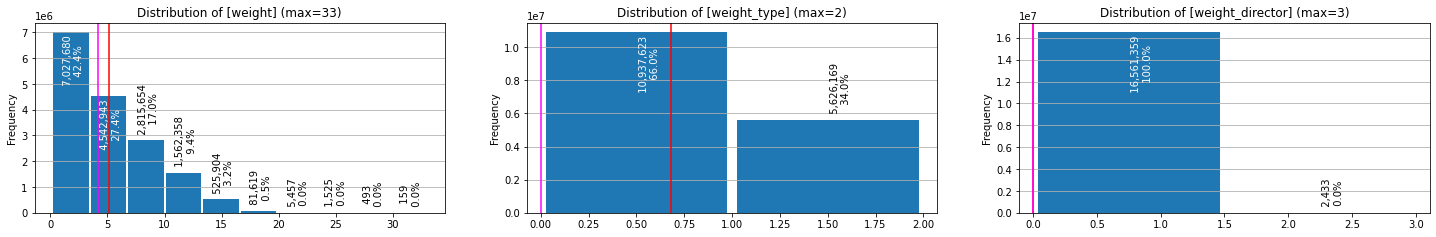

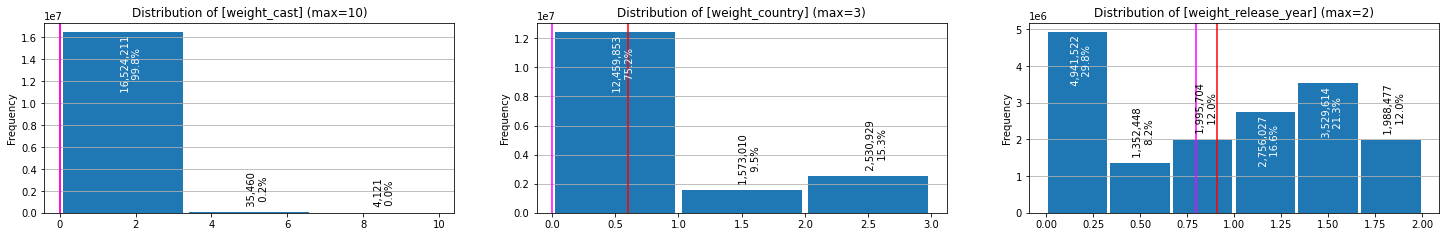

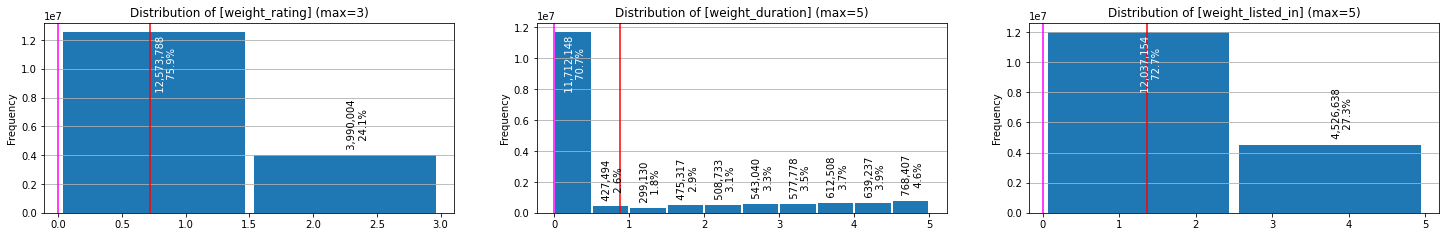

In [19]:
for i, column in enumerate(weight_columns):
  if (i % 3 == 0): axes = plt.subplots(ncols=3, figsize=(25, 3.5))[1]

  df_weights[column].plot.hist(ax=axes.flat[i%3], rwidth=0.95,
    bins=min(10, df_weights[column].nunique()), title=f'Distribution of [{column}] '
    + f'(max={weight_factors.get(column[7:], sum(weight_factors.values()))})').grid(axis='y')

  va_split = axes.flat[i%3].get_ylim()[1] * 0.5
  for patch in axes.flat[i%3].patches: y = patch._height; \
    axes.flat[i%3].annotate(f'  {y:0,.0f} \n  {y/len(df_weights):0.1%} ',
      [patch.xy[0]+patch._width/1.75, y], rotation=90, ha='center',
      va=('top' if y > va_split else 'bottom'), color=('white' if y > va_split else 'black'))

  for line in [(df_weights[column].mean(), 'red'), (df_weights[column].median(), 'magenta')]:
    axes.flat[i%3].axvline(line[0], color=line[1])

## 4.3 Small exploration of weights

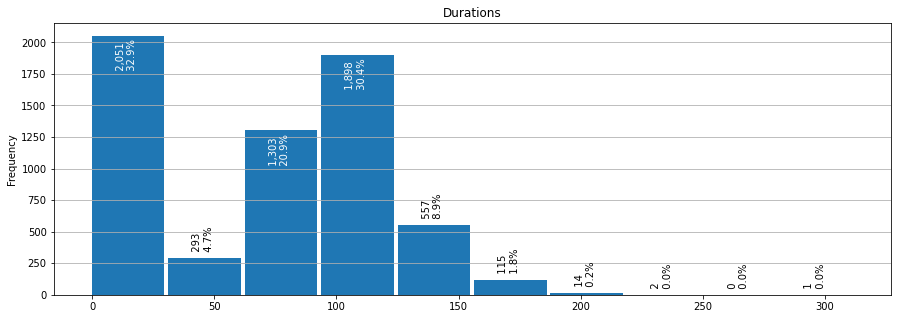

In [20]:
# Why are there sooo many items with weight_duration=0, although we distribute over a range of 60 minutes?
# Answer: we assign weight_duration=0 to all TV-Shows - that's about 30% of all the data!

df_netflix['duration'].plot.hist(figsize=(15, 5), rwidth=0.95, title='Durations').grid(axis='y')

va_split = plt.ylim()[1] * 0.5
for patch in plt.gca().patches: y = patch._height; \
  plt.annotate(f'  {y:0,.0f} \n  {y/len(df_netflix):0.1%} ', [patch.xy[0]+patch._width/3, y],
    rotation=90, va=('top' if y > va_split else 'bottom'), color=('white' if y > va_split else 'black'))

In [21]:
df_max_weight = df_weights.nlargest(1, 'weight', 'all')
print('There are', len(df_max_weight), 'movie-pairs with maximum weight:')
df_max_weight.reset_index()

There are 17 movie-pairs with maximum weight:


,source,target,weight,weight_type,weight_director,weight_cast,weight_country,weight_release_year,weight_rating,weight_duration,weight_listed_in
0,81186758,81186757,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
1,81021243,80235524,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
2,81075235,81072516,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
3,81083971,81074135,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
4,80191357,80191358,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
5,80158580,80158579,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
6,80158580,80158581,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
7,80158579,80158581,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
8,80220814,81046962,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0
9,80019930,70301472,33.0,2.0,3.0,10.0,3.0,2.0,3.0,5.0,5.0


In [22]:
for pair in df_weights.nlargest(1, 'weight', 'all').index:
  display(df_netflix.loc[[*pair]].reset_index())

,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81186758,{Epic},Oh! Baby (Malayalam),{B. V. Nandini Reddy},"{Aishwarya, Jagapathi Babu, Teja Sajja, Samant...",{India},2019,{TV-14},146,"{International Movies, Comedies, Music & Music...",A surly septuagenarian gets another chance at ...
1,81186757,{Epic},Oh! Baby (Tamil),{B. V. Nandini Reddy},"{Aishwarya, Jagapathi Babu, Teja Sajja, Samant...",{India},2019,{TV-14},146,"{International Movies, Comedies, Music & Music...",A surly septuagenarian gets another chance at ...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81021243,{Short},Super Monsters: Vida's First Halloween,"{Steve Ball, Jacob Joice}","{Nicole Anthony, Alessandro Juliani, Vincent T...",{United States},2019,{TV-Y},24,{Children & Family Movies},The Super Monsters share their Halloween tradi...
1,80235524,{Short},Super Monsters Save Christmas,{Steve Ball},"{Nicole Anthony, Vincent Tong, Diana Kaarina, ...",{United States},2019,{TV-Y},24,{Children & Family Movies},"It's Christmas Eve in Pitchfork Pines, and the..."


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81075235,{Epic},Sarkar,{A.R. Murugadoss},"{Radha Ravi, Yogi Babu, Keerthi Suresh, Vijay,...",{India},2018,{TV-MA},162,"{Dramas, Action & Adventure, International Mov...",A ruthless businessman’s mission to expose ele...
1,81072516,{Epic},Sarkar,{A.R. Murugadoss},"{Radha Ravi, Yogi Babu, Keerthi Suresh, Vijay,...",{India},2018,{TV-MA},162,"{Dramas, Action & Adventure, International Mov...",A ruthless businessman’s mission to expose ele...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81083971,{Epic},Sarvam Thaala Mayam (Tamil Version),{Rajiv Menon},"{Aparna Balamurali, G.V. Prakash Kumar, Divyad...",{India},2018,{TV-14},131,"{Dramas, International Movies, Music & Musicals}",An aspiring musician battles age-old caste div...
1,81074135,{Epic},Sarvam Thaala Mayam (Telugu Version),{Rajiv Menon},"{Aparna Balamurali, G.V. Prakash Kumar, Divyad...",{India},2018,{TV-14},131,"{Dramas, International Movies, Music & Musicals}",An aspiring musician battles age-old caste div...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80191357,{Movie},Bruno and Boots: This Can't Be Happening at Ma...,{Vivieno Caldinelli},"{Jonny Gray, Callan Potter, Peter Keleghan, Ca...",{Canada},2017,{TV-PG},90,"{Children & Family Movies, Comedies}",The biggest troublemakers at Macdonald Hall ar...
1,80191358,{Movie},Bruno and Boots: The Wizzle War,{Vivieno Caldinelli},"{Caroline Rhea, Kiana Madeira, Jonny Gray, Mat...",{Canada},2017,{TV-PG},90,"{Children & Family Movies, Comedies}",Fed up with weird dress codes and wacky punish...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80158580,{Episode},Amelia: A Tale of Two Sisters,{Edward Cotterill},{Rachael Stirling},{United Kingdom},2017,{TV-PG},44,{Documentaries},"Eight decades after her disappearance, Amelia ..."
1,80158579,{Episode},Jackie: A Tale of Two Sisters,{Edward Cotterill},{Rachael Stirling},{United Kingdom},2017,{TV-PG},44,{Documentaries},Rachael Stirling narrates this multifaceted po...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80158580,{Episode},Amelia: A Tale of Two Sisters,{Edward Cotterill},{Rachael Stirling},{United Kingdom},2017,{TV-PG},44,{Documentaries},"Eight decades after her disappearance, Amelia ..."
1,80158581,{Episode},The Mitfords: A Tale of Two Sisters,{Edward Cotterill},{Rachael Stirling},{United Kingdom},2017,{TV-PG},44,{Documentaries},Jessica and Diana were sisters who were separa...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80158579,{Episode},Jackie: A Tale of Two Sisters,{Edward Cotterill},{Rachael Stirling},{United Kingdom},2017,{TV-PG},44,{Documentaries},Rachael Stirling narrates this multifaceted po...
1,80158581,{Episode},The Mitfords: A Tale of Two Sisters,{Edward Cotterill},{Rachael Stirling},{United Kingdom},2017,{TV-PG},44,{Documentaries},Jessica and Diana were sisters who were separa...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80220814,{Epic},Solo: A Star Wars Story,{Ron Howard},"{Emilia Clarke, Alden Ehrenreich, Woody Harrel...",{United States},2018,{PG-13},135,"{Children & Family Movies, Action & Adventure,...",A young Han Solo tries to settle an old score ...
1,81046962,{Epic},Solo: A Star Wars Story (Spanish Version),{Ron Howard},"{Emilia Clarke, Alden Ehrenreich, Woody Harrel...",{United States},2018,{PG-13},135,"{Children & Family Movies, Action & Adventure,...",A young Han Solo tries to settle an old score ...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80019930,{Episode},Monster High: Freaky Fusion,"{Sylvain Blais, William Lau}","{Paula Rhodes, Cam Clarke, Stephanie Sheh, Lau...",{United States},2014,{TV-Y7},74,{Children & Family Movies},"When Frankie Stein travels back in time, a tee..."
1,70301472,{Episode},"Monster High: Frights, Camera, Action!",{William Lau},"{Celeste Henderson, Karen Strassman, Yeni Alva...",{United States},2014,{TV-Y7},74,{Children & Family Movies},Draculaura is whisked to Transylvania to be cr...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,70286028,{Episode},Monster High: Friday Night Frights,{Dustin McKenzie},"{Debi Derryberry, Evan Smith, Julie Maddalena,...",{United States},2013,{TV-Y7},46,{Children & Family Movies},In their bid to win the Skulltimate Roller Maz...
1,70286029,{Episode},Monster High: Why Do Ghouls Fall in Love?,"{Dustin McKenzie, Steve Sacks}","{Debi Derryberry, Evan Smith, Cam Clarke, Ogie...",{United States},2013,{TV-Y7},46,{Children & Family Movies},Draculaura's ghoulfriends have some suspicions...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80203998,{Epic},Baahubali 2: The Conclusion (Malayalam Version),{S.S. Rajamouli},"{Ramya Krishnan, Nassar, Sathyaraj, Subbaraju,...",{India},2017,{TV-MA},166,"{Dramas, Action & Adventure, International Mov...","To avenge his father's death, a young man lead..."
1,80203997,{Epic},Baahubali 2: The Conclusion (Tamil Version),{S.S. Rajamouli},"{Ramya Krishnan, Nassar, Sathyaraj, Subbaraju,...",{India},2017,{TV-MA},166,"{Dramas, Action & Adventure, International Mov...","To avenge his father's death, a young man lead..."


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80204117,{Epic},Baahubali: The Beginning (Hindi Version),{S.S. Rajamouli},"{Nassar, Ramya Krishnan, Sathyaraj, Sudeep, Pr...",{India},2015,{TV-14},159,"{Dramas, Action & Adventure, International Mov...",Villagers in the kingdom of Mahismati rescue a...
1,80204118,{Epic},Baahubali: The Beginning (Tamil Version),{S.S. Rajamouli},"{Nassar, Ramya Krishnan, Sathyaraj, Sudeep, Pr...",{India},2015,{TV-14},159,"{Dramas, Action & Adventure, International Mov...",Villagers in the kingdom of Mahismati rescue a...


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81151880,{Movie},Game Over (Hindi Version),{Ashwin Saravanan},"{Taapsee Pannu, David Solomon Raja, Parvathi T...","{India, Turkey}",2019,{TV-MA},98,"{Thrillers, International Movies, Horror Movies}","As a series of murders hit close to home, a vi..."
1,81151877,{Movie},Game Over (Tamil Version),{Ashwin Saravanan},"{Taapsee Pannu, David Solomon Raja, Parvathi T...","{India, Turkey}",2019,{TV-MA},98,"{Thrillers, International Movies, Horror Movies}","As a series of murders hit close to home, a vi..."


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81151880,{Movie},Game Over (Hindi Version),{Ashwin Saravanan},"{Taapsee Pannu, David Solomon Raja, Parvathi T...","{India, Turkey}",2019,{TV-MA},98,"{Thrillers, International Movies, Horror Movies}","As a series of murders hit close to home, a vi..."
1,81151878,{Movie},Game Over (Telugu Version),{Ashwin Saravanan},"{Taapsee Pannu, David Solomon Raja, Parvathi T...","{India, Turkey}",2019,{TV-MA},98,"{Thrillers, International Movies, Horror Movies}","As a series of murders hit close to home, a vi..."


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81151877,{Movie},Game Over (Tamil Version),{Ashwin Saravanan},"{Taapsee Pannu, David Solomon Raja, Parvathi T...","{India, Turkey}",2019,{TV-MA},98,"{Thrillers, International Movies, Horror Movies}","As a series of murders hit close to home, a vi..."
1,81151878,{Movie},Game Over (Telugu Version),{Ashwin Saravanan},"{Taapsee Pannu, David Solomon Raja, Parvathi T...","{India, Turkey}",2019,{TV-MA},98,"{Thrillers, International Movies, Horror Movies}","As a series of murders hit close to home, a vi..."


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81091424,{Epic},Petta (Telugu Version),{Karthik Subbaraj},"{Nawazuddin Siddiqui, Vijay Sethupathi, M. Sas...",{India},2019,{TV-14},170,"{Dramas, Action & Adventure, Comedies}","An affable, newly appointed college warden pro..."
1,81091423,{Epic},Petta,{Karthik Subbaraj},"{Nawazuddin Siddiqui, Vijay Sethupathi, M. Sas...",{India},2019,{TV-14},170,"{Dramas, Action & Adventure, Comedies}","An affable, newly appointed college warden pro..."


In [23]:
df_weights.query('weight_cast > 7').reset_index()

,source,target,weight,weight_type,weight_director,weight_cast,weight_country,weight_release_year,weight_rating,weight_duration,weight_listed_in
0,81145628,81065331,32.666667,2.0,3.0,10.0,3.0,2.0,3.0,4.666667,5.0
1,70234439,80058654,20.800000,2.0,0.0,10.0,3.0,0.8,0.0,0.000000,5.0
2,70234439,80057610,23.800000,2.0,0.0,10.0,3.0,0.8,3.0,0.000000,5.0
3,70234439,80180600,20.000000,2.0,0.0,10.0,0.0,0.0,3.0,0.000000,5.0
4,70234439,80023667,14.200000,0.0,0.0,10.0,3.0,1.2,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4116,70309457,70205024,24.600000,2.0,0.0,10.0,3.0,1.6,3.0,0.000000,5.0
4117,70204957,80065146,24.200000,2.0,0.0,10.0,3.0,1.2,3.0,0.000000,5.0
4118,80065146,70204981,24.200000,2.0,0.0,10.0,3.0,1.2,3.0,0.000000,5.0
4119,70177034,60036794,24.600000,2.0,0.0,10.0,3.0,1.6,3.0,0.000000,5.0


In [24]:
display(df_weights.query('source==80003152 and target==80003153').reset_index())
df_netflix.loc[[80003152, 80003153]].reset_index()

,source,target,weight,weight_type,weight_director,weight_cast,weight_country,weight_release_year,weight_rating,weight_duration,weight_listed_in
0,80003152,80003153,30.0,2.0,0.0,10.0,3.0,2.0,3.0,5.0,5.0


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,80003152,{Episode},Secrets of Henry VIII's Palace: Hampton Court,{Sam Taplin},{Samuel West},{United States},2013,{TV-PG},54,"{International Movies, Documentaries}",The history of this grand 500-year-old palace ...
1,80003153,{Episode},Secrets of Highclere Castle,{Vicky Matthews},{Samuel West},{United States},2013,{TV-PG},54,"{International Movies, Documentaries}","Known as the setting of ""Downton Abbey,"" Highc..."


In [25]:
display(df_weights.query('source==81030855 and target==81044248').reset_index())
df_netflix.loc[[81030855, 81044248]].reset_index()

,source,target,weight,weight_type,weight_director,weight_cast,weight_country,weight_release_year,weight_rating,weight_duration,weight_listed_in
0,81030855,81044248,20.0,2.0,0.0,0.0,3.0,2.0,3.0,5.0,5.0


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in,description
0,81030855,{Movie},Alles ist gut,{Eva Trobisch},"{Lisa Hagmeister, Tilo Nest, Hans Löw, Aenne S...",{Germany},2019,{TV-MA},90,"{Dramas, International Movies}",A woman sexually assaulted by her new boss's b...
1,81044248,{Movie},Kidnapping Stella,{Thomas Sieben},"{Max von der Groeben, Clemens Schick, Jella Ha...",{Germany},2019,{TV-MA},90,"{Dramas, International Movies, Thrillers}","Snatched off the street and held for ransom, a..."


---
# 5 Plot some Graphs

In [ ]:
# Prepare dicts for sizing and colouring of nodes and edges

# node_degrees: Anzahl der Kanten pro Knoten
# Achtung: Dict ist vorsortiert, Knoten mit niedrigem Gewicht zuerst 
node_degrees = {node: (weight/666)**3 for node, weight in 
  sorted(G_netflix.degree, key=lambda kv: kv[1])}
# Noch eine Möglichkeit: Kanten filtern auf Minimal-Gewicht 15
# node_degrees = pd.DataFrame(index=G_netflix.nodes, data={
#   'out':df_weights.query('weight > 15').groupby('source')['weight'].count(),
#   'in': df_weights.query('weight > 15').groupby('target')['weight'].count(),
#   }).agg(sum, axis='columns').apply(lambda weight: weight * 4) \
#   .sort_values().to_dict()

# node_weights: Summe der Kanten-Gewichte pro Knoten
# Achtung: Dict muss die gleiche Reihenfolge haben wie node_degrees!
node_weights = dict(sorted(G_netflix.degree(weight='weight'),
  key=lambda kv: node_degrees[kv[0]]))
# Noch eine Möglichkeit: Kanten filtern auf Minimal-Gewicht 15
# node_weights = pd.DataFrame(index=G_netflix.nodes, data={
#   'out':df_weights.query('weight > 15').groupby('source')['weight'].sum(),
#   'in': df_weights.query('weight > 15').groupby('target')['weight'].sum(),
#   }).agg(sum, axis='columns').sort_values().to_dict()

# edge_weights: vorsortiertes Dict von Kanten, niedriges Gewicht zuerst
edge_weights = df_weights.nlargest(5_000, 'weight', 'all')['weight'] \
  .apply(lambda weight: (weight/22)**5).sort_values().to_dict()

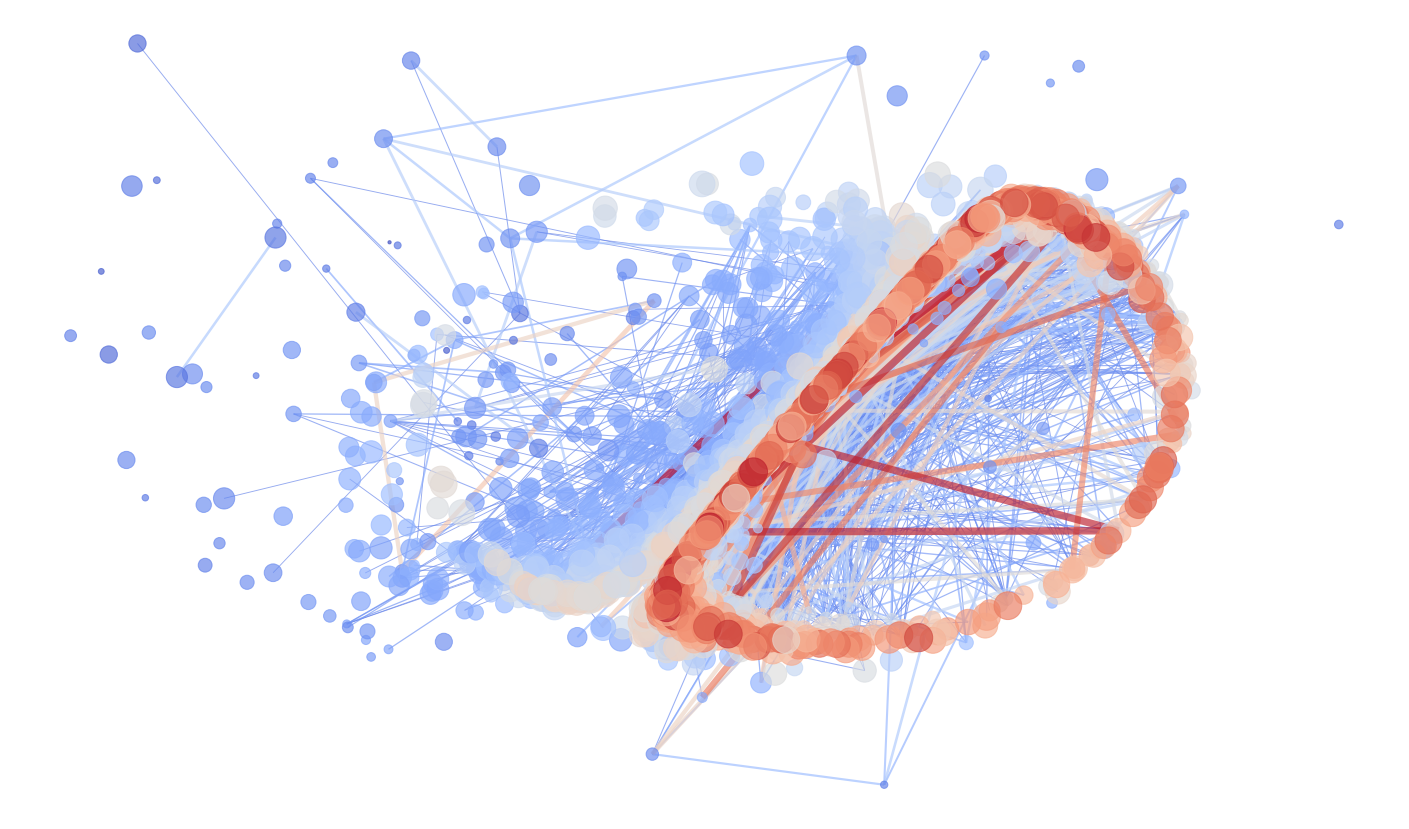

In [ ]:
# visualize ALL NODES and TOP EDGES

def plot_graph(edge_weights=edge_weights):
  nx.draw(G_netflix, layout, ax=plt.subplots(figsize=(25, 15))[1], # Alle Knoten, Top-n Kanten
    nodelist=node_degrees, node_size=list(node_degrees.values()),  # Knoten: Anzahl der Kanten
    node_color=list(node_weights.values()), cmap='coolwarm',       # Knoten: Summe der Kanten-Gewichte
    edgelist=edge_weights, edge_color=list(edge_weights.values()), # Kanten: Gewicht pro Kante
    edge_cmap=plt.cm.coolwarm, edge_vmin=0, width=list(edge_weights.values()), alpha=0.66)

plot_graph()

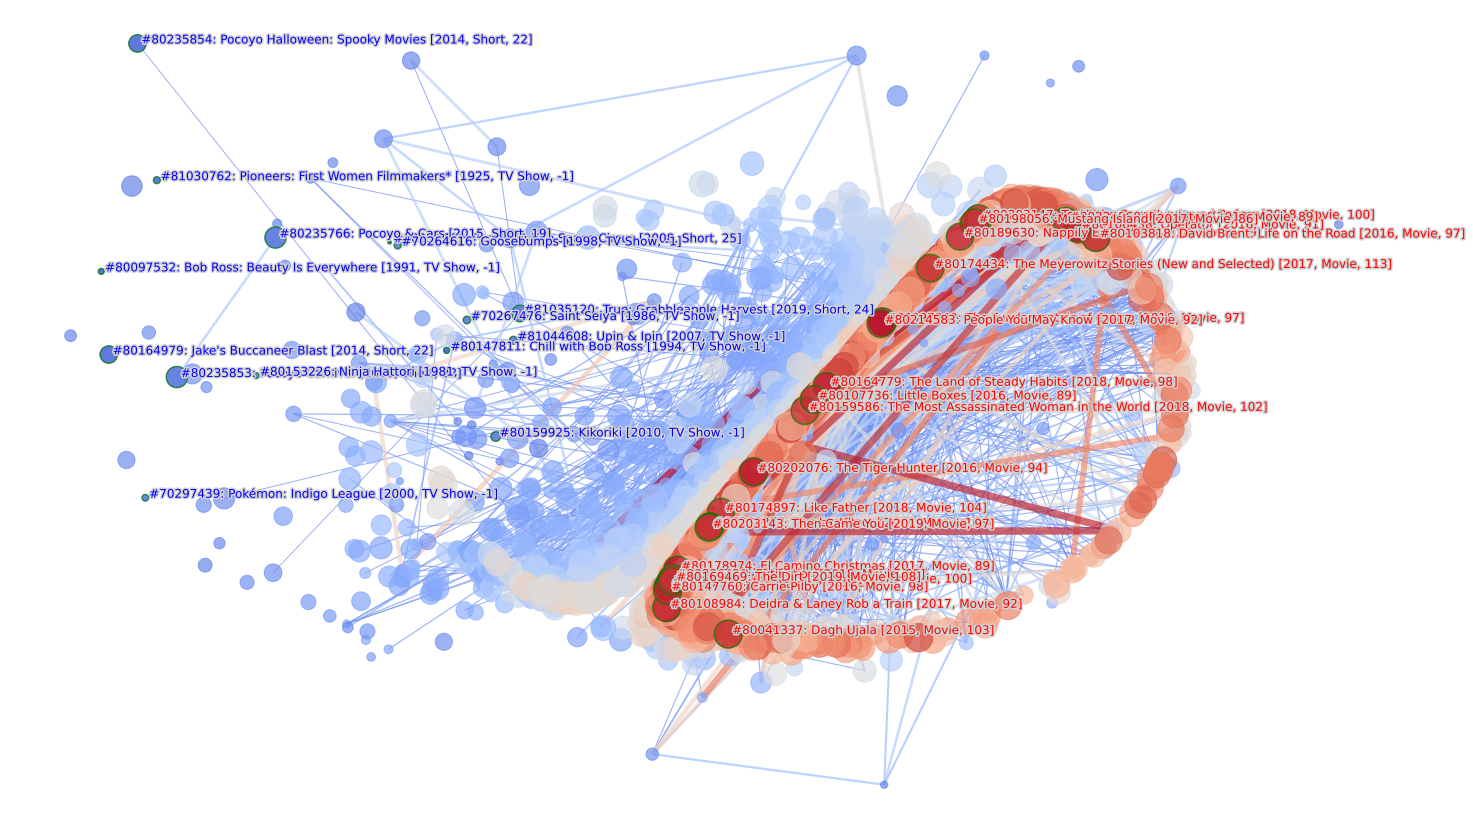

In [ ]:
# visualize ALL NODES, TOP EDGES and TOP/FLOP LABELS

def plot_special(node_list, label_color, highlight_edges=False):
  nx.draw_networkx_nodes(G_netflix, layout, nodelist=node_list, # Top-n Knoten nochmal deckend
    node_size=[node_degrees[node] for node in node_list],       # Anzahl der Kanten
    node_color=[node_weights[node] for node in node_list],      # Summe der Kanten-Gewichte
    vmin=min(node_weights.values()), vmax=max(node_weights.values()),
    cmap='coolwarm', linewidths=1.5, edgecolors='green', alpha=0.66)

  for node in node_list:                                        # Top-n Knoten beschriften
    plt.annotate(' #{show_id}: {title} [{release_year}, {type}, {duration}]' \
      .format(**df_netflix.loc[[node]].reset_index().loc[0]).replace("{'", '') \
      .replace("'}", ''), layout[node], color=label_color, size=12) \
      ._path_effects=[withStroke(linewidth=3, foreground='lightgrey')]

  if (highlight_edges):
    edge_list = df_weights.query('(source in @node_list) and (target in @node_list)') \
      ['weight'].apply(lambda weight: max(2, (weight/22)**5)).to_dict()
    nx.draw_networkx_edges(G_netflix, layout, edgelist=edge_list, edge_color='green',
      width=list(edge_list.values()), style='--', alpha=0.66).zorder=2

plot_graph() # visualize ALL NODES and TOP EDGES

# Add some TOP and FLOP LABELs
for top_flop, node_count, label_color in [(True, 25, 'red'), (False, 15, 'blue')]:
  node_list = sorted(node_weights, key=lambda key: node_weights[key], reverse=top_flop)[:node_count]
  plot_special_nodes(node_list, label_color)

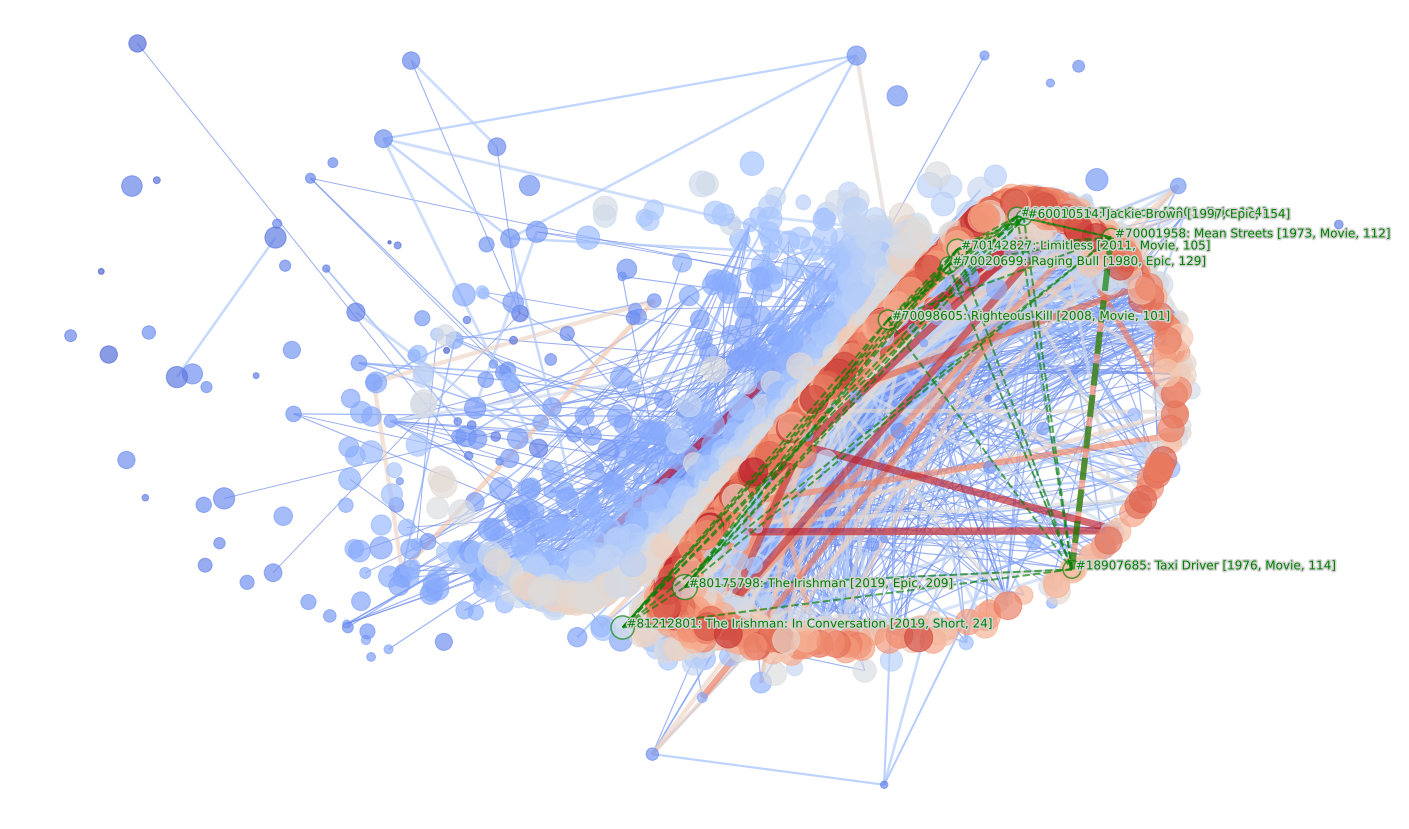

In [ ]:
# Remember those films with Robert De Niro?

plot_graph() # visualize ALL NODES and TOP EDGES

# Add the films with Robert De Niro!
plot_special_nodes(deniro_films, 'green', highlight_edges=True)

# 6 Finally, recommendations!

## 6.1 Define Function `get_weight_DF`

In [26]:
def get_weight_DF(myGraph):
  #print('Creating DataFrame with all weights from graph, stand by...'); t0 = time()

  df_weights = pd.DataFrame()
  for i, column in enumerate(weight_columns):
    #print(f'[{"%2d:%02d" % divmod(time()-t0, 60)}] Processing column [{column}]...')
    df_weights[column] = pd.Series(nx.get_edge_attributes(myGraph, column),dtype=np.float)
  df_weights.rename_axis(['source', 'target'], inplace=True)
  df_weights.fillna(0, inplace=True)

  #print(f'\nDataFrame created in {"%d:%02d" % divmod(time()-t0, 60)} minutes.')

  return df_weights

## 6.2 Define DF Format


In [27]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

## 6.3 Create Sub-Graph and Sub-Weights


In [31]:
def create_matrix(myG, last_seen, normalized=True):
  # normalized = True : all values are normalized to their max value
  # normalized = False: no normalization at all
  # normalized = 'weight': only total weight column will be normalized

  # calculated weight matrix for subgraph
  my_weights = get_weight_DF(myG)
  my_weights.reset_index(level=0, drop=True, inplace=True)

  # normalize weights to max value
  if normalized == 'weight':
    my_weights.weight = my_weights.weight / sum(weight_factors.values())
  elif normalized:
    my_weights.weight = my_weights.weight / sum(weight_factors.values())
    for key in weight_factors:
      my_weights['weight_' + key] = my_weights['weight_' + key] / weight_factors[key]
    
  return my_weights

## 6.4 Display Function

In [32]:
def show_recommendation(last_seen, weight_matrix, normalized=True):
  # join weights with original data
  
  print(f'\n\nBest recommendations for #{last_seen}:\33[103;1m >> {df_netflix.loc[last_seen].title} << \33[0m')
  with pd.option_context('max_colwidth', 275):
    display(df_netflix.loc[[last_seen]].drop(columns='description').reset_index())
  print()

  df_display = pd.concat([weight_matrix, df_netflix], axis='columns', join='inner') \
    .rename_axis('show_id').sort_values(['weight'], ascending=False)[:10] \
    [('title weight type weight_type director weight_director weight_cast weight_country ' \
      + 'release_year weight_release_year rating weight_rating duration weight_duration weight_listed_in').split()]
  
  if normalized == 'weight':
    df_display['weight'] = pd.Series(["{0:7.2%}".format(val) for val in df_display['weight']], index=df_display.index)
    for column in weight_columns[1:]:
      df_display[column] = pd.Series(["{0:5.2f}".format(val) for val in df_display[column]], index=df_display.index)
  elif normalized:
    for column in weight_columns:
      df_display[column] = pd.Series(["{0:7.2%}".format(val) for val in df_display[column]], index=df_display.index)
  else: 
    for column in weight_columns:
        df_display[column] = pd.Series(["{0:5.2f}".format(val) for val in df_display[column]], index=df_display.index)

  with pd.option_context('max_colwidth', 10):
    display(df_display.reset_index().style.apply(highlight_max, subset=weight_columns))

  plot_graph(dict(sorted(nx.get_edge_attributes(G_sub, 'weight').items(), key=lambda kv: kv[1])[:5_000]))
  plot_special_nodes([last_seen, *df_display.index], 'green', highlight_edges=True)

## 6.5 Recommender

In [33]:
# remember the Bruce films?
# 80187228, 70021630, 292118, 70044870, 684847, 70199239, 70058019, 880640, 60026139, 80013712

last_seen = 80187228 # "First Kill" with Bruce Willis
#last_seen = 70021630 # "Sin City" with Bruce Willis
#last_seen = 28631029 # "Stuart Little" (Children / family movie)
#last_seen = 80158580 # Two Sisters episodes
last_seen = 80235854 # some strange kind of film???

# normalized = True : all values are normalized to their max value
# normalized = False: no normalization at all
# normalized = 'weight': only total weight column will be normalized
norm = 'weight'

# create subgraph only with neighbors and direct edges
G_sub = nx.Graph(G_netflix.edges(last_seen, data=True), name='G_sub')
print(nx.info(G_sub))

weight_matrix = create_matrix(G_sub, last_seen, normalized=norm)
show_recommendation(last_seen, weight_matrix, normalized=norm)

Name: G_sub
Type: Graph
Number of nodes: 4457
Number of edges: 4456
Average degree:   1.9996


Best recommendations for #80235854: >> Pocoyo Halloween: Spooky Movies << 


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in
0,80235854,{Short},Pocoyo Halloween: Spooky Movies,{},"{Stephen Fry, Montana Smedley}",{},2014,{TV-G},22,{Movies}


,show_id,title,weight,type,weight_type,director,weight_director,weight_cast,weight_country,release_year,weight_release_year,rating,weight_rating,duration,weight_duration,weight_listed_in
0,80236099,Pocoyo Halloween: Space Halloween,65.45%,{'Episode'},0.00,set(),0.00,10.00,0.00,2015,1.60,{'TV-G'},3.00,40,2.00,5.00
1,80235767,Pocoyo & The Space Circus,59.09%,{'Short'},2.00,{'Alfonso Rodríguez'},0.00,5.00,0.00,2008,0.00,{'TV-G'},3.00,25,4.50,5.00
2,80235853,Pocoyo Carnival,56.36%,{'Short'},2.00,set(),0.00,5.00,0.00,2015,1.60,{'TV-Y'},0.00,22,5.00,5.00
3,80235766,Pocoyo & Cars,54.85%,{'Short'},2.00,set(),0.00,5.00,0.00,2015,1.60,{'TV-Y'},0.00,19,4.50,5.00
4,80065492,Lego DC Comics: Batman Be-Leaguered,42.42%,{'Short'},2.00,{'Rick Morales'},0.00,0.00,0.00,2014,2.00,{'TV-Y7'},0.00,22,5.00,5.00
5,80164979,Jake's Buccaneer Blast,42.42%,{'Short'},2.00,set(),0.00,0.00,0.00,2014,2.00,{'TV-Y'},0.00,22,5.00,5.00
6,80019503,BoJack Horseman Christmas Special: Sabrina's Christmas Wish,40.40%,{'Short'},2.00,set(),0.00,0.00,0.00,2014,2.00,{'TV-MA'},0.00,26,4.33,5.00
7,80163222,A Christmas Special: Miraculous: Tales of Ladybug & Cat Noir,40.00%,{'Short'},2.00,{'Thomas Astruc'},0.00,0.00,0.00,2016,1.20,{'TV-Y7'},0.00,22,5.00,5.00
8,70242897,Power Rangers Super Samurai: Trickster Treat,39.49%,{'Short'},2.00,set(),0.00,0.00,0.00,2012,1.20,{'TV-Y7-FV'},0.00,23,4.83,5.00
9,80236224,Pocoyo Special Sports,38.99%,{'Short'},2.00,"{'David Cantolla', 'Guillermo Garcia'}",0.00,0.00,0.00,2016,1.20,{'TV-Y'},0.00,24,4.67,5.00


NameError: ignored

# 7 Remove Low Weighted Edges

## 7.1 Reduce Graph

In [ ]:
# expected execution time: 3-5 minutes (with threshold = 15)

G_reduced = G_netflix.copy(); G_reduced.name = 'G_reduced'
print(nx.info(G_reduced))

threshold = 15
too_low = df_weights[df_weights.weight < threshold].index

G_reduced.remove_edges_from(too_low)
print('\n' + nx.info(G_reduced))

Name: G_reduced
Type: Graph
Number of nodes: 6234
Number of edges: 16563792
Average degree: 5314.0173

Name: G_reduced
Type: Graph
Number of nodes: 6234
Number of edges: 270055
Average degree:  86.6394


## 7.2 Check Result

Name: G_sub
Type: Graph
Number of nodes: 89
Number of edges: 88
Average degree:   1.9775


Best recommendations for #80187228: >> First Kill << 


,show_id,type,title,director,cast,country,release_year,rating,duration,listed_in
0,80187228,{Movie},First Kill,{Steven C. Miller},"{Ty Shelton, William DeMeo, Tyler Jon Olson, Bruce Willis, Shea Buckner, Megan Leonard, Christine Dye, Gethin Anthony, Hayden Christensen, Magi Avila}","{United Kingdom, United States, Canada}",2017,{R},102,{Action & Adventure}


,show_id,title,weight,type,weight_type,director,weight_director,weight_cast,weight_country,release_year,weight_release_year,rating,weight_rating,duration,weight_duration,weight_listed_in
0,80013712,The Prince,21.97,{'Movie'},2.00,{'Brian A. Miller'},0.00,5.00,3.00,2014,0.80,{'R'},3.00,91,3.17,5.00
1,80017261,American Heist,21.13,{'Movie'},2.00,{'Sarik Andreasyan'},0.00,5.00,1.50,2014,0.80,{'R'},3.00,95,3.83,5.00
2,684847,The Last Boy Scout,21.00,{'Movie'},2.00,{'Tony Scott'},0.00,5.00,1.50,1991,0.00,{'R'},3.00,105,4.50,5.00
3,80189853,Beyond Skyline,19.17,{'Movie'},2.00,"{""Liam O'Donnell""}",0.00,0.00,3.00,2017,2.00,{'R'},3.00,107,4.17,5.00
4,70199239,Set Up,18.67,{'Movie'},2.00,{'Mike Gunther'},0.00,5.00,1.50,2011,0.00,{'R'},3.00,85,2.17,5.00
5,70044870,16 Blocks,18.50,{'Movie'},2.00,{'Richard Donner'},0.00,5.00,1.50,2006,0.00,{'PG-13'},0.00,102,5.00,5.00
6,80189216,In Search of Fellini,18.33,{'Movie'},2.00,{'Taron Lexton'},0.00,0.00,1.50,2017,2.00,{'R'},3.00,103,4.83,5.00
7,70299204,Kidnapping Mr. Heineken,18.03,{'Movie'},2.00,{'Daniel Alfredson'},0.00,0.00,3.00,2015,1.20,{'R'},3.00,95,3.83,5.00
8,70061480,War,17.83,{'Movie'},2.00,{'Philip G. Atwell'},0.00,0.00,3.00,2007,0.00,{'R'},3.00,103,4.83,5.00
9,80039602,Skin Trade,17.80,{'Movie'},2.00,{'Ekachai Uekrongtham'},0.00,0.00,3.00,2014,0.80,{'R'},3.00,96,4.00,5.00


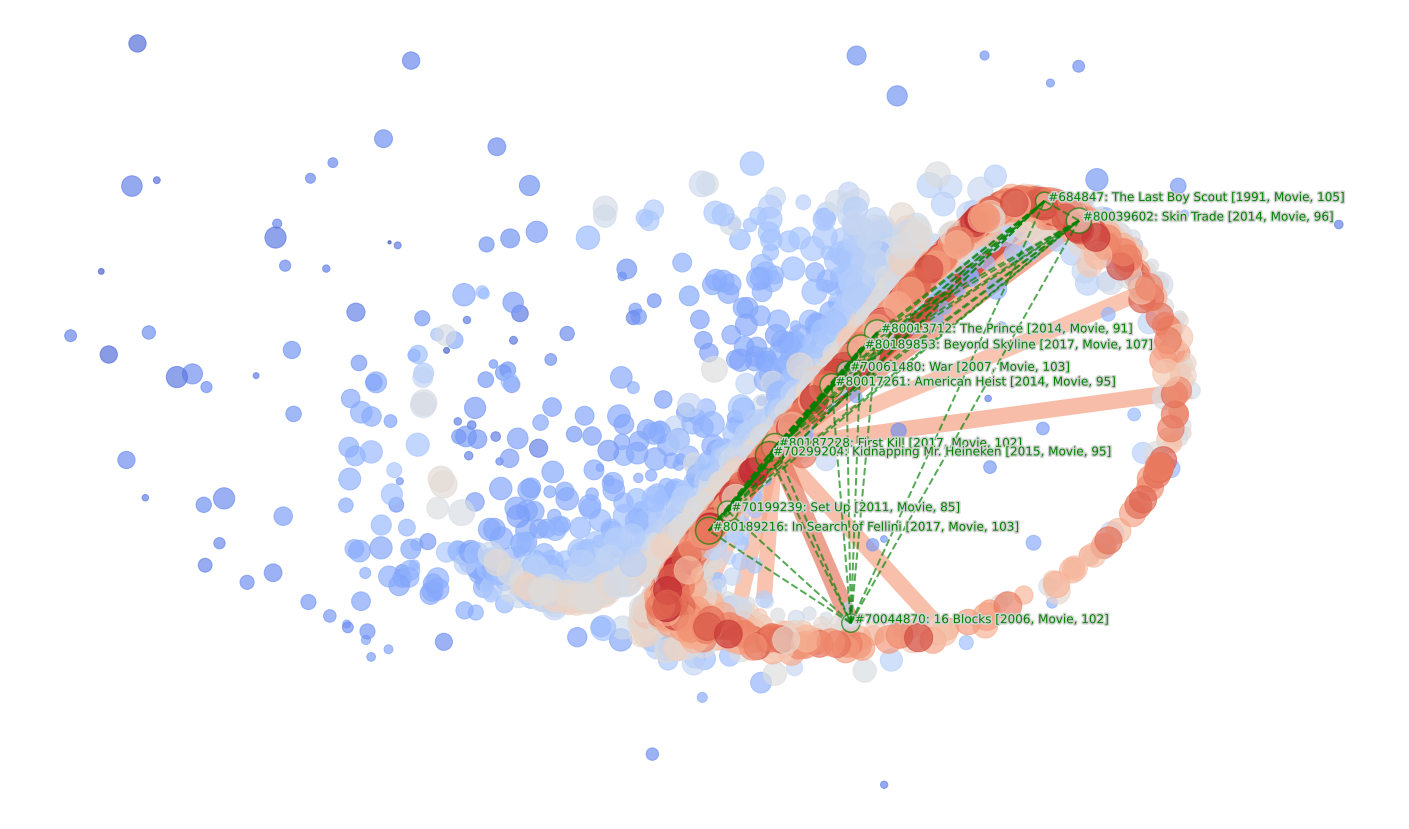

In [ ]:
# expected execution time: < 1 minute (85 average degree)

G_sub = nx.Graph(G_reduced.edges(last_seen, data=True), name='G_sub')
print(nx.info(G_sub))

norm = False
weight_matrix_sub = create_matrix(G_sub, last_seen, normalized=norm)
show_recommendation(last_seen, weight_matrix_sub, normalized=norm)

## 7.3 Add Indirect Neighbors


### 7.3.1 Application to the Fuck-up night

Wir haben erst sehr spät erkannt, das weight eine **Strafe (penalty)** ist, keine **positiven Punkte (bonus)**.

früher: schlecht=0, gut=33  
jetzt:  schlecht=33, gut=0  

Wie geht die Inversion?

```
**weight total: max 33**  
input:  22  
invert: 22/33 = 0.66  
        1-0.66 = 0.33  
        0.33*33 = 11  
result: 11

**weight total: max 33**  
input:  33  
invert: 33/33 = 1  
        1-1 = 0  
        0*33 = 0  
result: 0

** feature cast: max 3**  
input:  2  
invert: 2/3 = 0.66  
        1-0.66 = 0.33  
        0.33*3 = 1
result: 1
```

In [ ]:
# correction of inverted weights
nx.set_edge_attributes(G_reduced, {node: sum(weight_factors.values()) / weight
  for (node, weight) in nx.get_edge_attributes(G_reduced, 'weight').items()},
  'weight_inv')

In [ ]:
# get shortes paths
weight_dict = nx.shortest_path_length(G_reduced, source=last_seen, target=None, weight='weight_inv', method='dijkstra')

df_dijkstra = pd.DataFrame(weight_dict.values(), columns=['distance'], index=weight_dict.keys()).drop(last_seen)
df_dijkstra = pd.concat([df_dijkstra, df_netflix], join='inner', axis=1)
display(df_dijkstra.head(15))

,distance,type,title,director,cast,country,release_year,rating,duration,listed_in,description
80013712,1.502276,{Movie},The Prince,{Brian A. Miller},"{50 Cent, Johnathon Schaech, Bruce Willis, Gia...","{United Kingdom, United States}",2014,{R},91,{Action & Adventure},A former Mafia hit man living quietly as a mec...
80017261,1.561514,{Movie},American Heist,{Sarik Andreasyan},"{Akon, Lance E. Nichols, Luis Da Silva Jr., Jo...","{Luxembourg, Canada}",2014,{R},95,"{Action & Adventure, Dramas}",An ex-con is just getting his life back on tra...
684847,1.571429,{Movie},The Last Boy Scout,{Tony Scott},"{Bruce McGill, Bruce Willis, Halle Berry, Tayl...",{United States},1991,{R},105,"{Action & Adventure, Comedies}",Private eye Joe Hallenbeck is forced to team u...
80189853,1.721739,{Movie},Beyond Skyline,{Liam O'Donnell},"{Bojana Novakovic, Pamelyn Chee, Jonny Weston,...","{Indonesia, China, United Kingdom, Singapore, ...",2017,{R},107,"{Sci-Fi & Fantasy, Action & Adventure}","In the wake of an extraterrestrial invasion, a..."
70199239,1.767857,{Movie},Set Up,{Mike Gunther},"{50 Cent, Bruce Willis, Ryan Phillippe, Susie ...",{United States},2011,{R},85,{Action & Adventure},"A diamond heist goes horribly wrong, and the g..."
70044870,1.783784,{Movie},16 Blocks,{Richard Donner},"{David Zayas, Jenna Stern, Sasha Roiz, Mos Def...","{United States, Germany}",2006,{PG-13},102,{Action & Adventure},Tasked with escorting a prosecution witness to...
80189216,1.800000,{Movie},In Search of Fellini,{Taron Lexton},"{Nancy Cartwright, Beth Riesgraf, Paolo Bernar...",{United States},2017,{R},103,"{Action & Adventure, Dramas}",A naive and sheltered young woman embarks on a...
70299204,1.829945,{Movie},Kidnapping Mr. Heineken,{Daniel Alfredson},"{David Dencik, Mark van Eeuwen, Ryan Kwanten, ...","{Netherlands, Belgium, United Kingdom, United ...",2015,{R},95,"{International Movies, Action & Adventure, Dra...","When beer magnate Alfred ""Freddy"" Heineken is ..."
70061480,1.850467,{Movie},War,{Philip G. Atwell},"{Mark Cheng, Kane Kosugi, Devon Aoki, John Lon...","{United States, Canada}",2007,{R},103,{Action & Adventure},When his partner is killed and all clues point...
80039602,1.853933,{Movie},Skin Trade,{Ekachai Uekrongtham},"{Celina Jade, Mike Dopud, Michael Jai White, R...","{United States, Thailand, Canada}",2014,{R},96,{Action & Adventure},A New Jersey detective whose family was killed...


# 8 Presentation Play Around

# 98 Ideen-Speicher




* bei akuter Langeweile: NLP auf description-Spalte + title => tags vergleichen

# 99 Log Dumps

## 1.1 File *netflix_graph.pickle.gz*




In [ ]:
"""
### LOG OF EXECUTION

# weight_factors:
('cast', 10)
('duration', 5)
('listed_in', 5)
('director', 3)
('country', 2)
('rating', 3)
('type', 2)
('release_year', 3)
SUM of factors = maximum total weight: 33

# weight_caps:
('country', 2)
('cast', 3)

[ 0:00] Processing   0%... combination:         0 of 19,428,261, nodes:    0, edges:         0
[ 0:08] Processing   0%... combination:    97,141 of 19,428,261, nodes:6,234, edges:    82,221
[ 0:17] Processing   1%... combination:   194,282 of 19,428,261, nodes:6,234, edges:   164,606
[ 0:26] Processing   1%... combination:   291,423 of 19,428,261, nodes:6,234, edges:   250,455
[ 0:35] Processing   2%... combination:   388,564 of 19,428,261, nodes:6,234, edges:   337,278
[ 0:44] Processing   2%... combination:   485,705 of 19,428,261, nodes:6,234, edges:   425,462
[ 0:53] Processing   3%... combination:   582,846 of 19,428,261, nodes:6,234, edges:   512,828
[ 1:02] Processing   3%... combination:   679,987 of 19,428,261, nodes:6,234, edges:   598,876
[ 1:11] Processing   4%... combination:   777,128 of 19,428,261, nodes:6,234, edges:   687,945
[ 1:20] Processing   4%... combination:   874,269 of 19,428,261, nodes:6,234, edges:   775,725
[ 1:29] Processing   5%... combination:   971,410 of 19,428,261, nodes:6,234, edges:   858,544
[ 1:38] Processing   5%... combination: 1,068,551 of 19,428,261, nodes:6,234, edges:   944,563
[ 1:47] Processing   6%... combination: 1,165,692 of 19,428,261, nodes:6,234, edges: 1,030,848
[ 1:56] Processing   6%... combination: 1,262,833 of 19,428,261, nodes:6,234, edges: 1,111,582
[ 2:05] Processing   7%... combination: 1,359,974 of 19,428,261, nodes:6,234, edges: 1,197,893
[ 2:14] Processing   7%... combination: 1,457,115 of 19,428,261, nodes:6,234, edges: 1,281,969
[ 2:23] Processing   8%... combination: 1,554,256 of 19,428,261, nodes:6,234, edges: 1,371,364
[ 2:41] Processing   8%... combination: 1,651,397 of 19,428,261, nodes:6,234, edges: 1,455,888
[ 2:55] Processing   9%... combination: 1,748,538 of 19,428,261, nodes:6,234, edges: 1,542,633
[ 3:04] Processing   9%... combination: 1,845,679 of 19,428,261, nodes:6,234, edges: 1,627,159
[ 3:13] Processing  10%... combination: 1,942,820 of 19,428,261, nodes:6,234, edges: 1,704,463
[ 3:22] Processing  10%... combination: 2,039,961 of 19,428,261, nodes:6,234, edges: 1,784,557
[ 3:31] Processing  11%... combination: 2,137,102 of 19,428,261, nodes:6,234, edges: 1,871,720
[ 3:40] Processing  11%... combination: 2,234,243 of 19,428,261, nodes:6,234, edges: 1,946,444
[ 3:49] Processing  12%... combination: 2,331,384 of 19,428,261, nodes:6,234, edges: 2,018,931
[ 3:58] Processing  12%... combination: 2,428,525 of 19,428,261, nodes:6,234, edges: 2,104,705
[ 4:07] Processing  13%... combination: 2,525,666 of 19,428,261, nodes:6,234, edges: 2,178,027
[ 4:16] Processing  13%... combination: 2,622,807 of 19,428,261, nodes:6,234, edges: 2,266,829
[ 4:25] Processing  14%... combination: 2,719,948 of 19,428,261, nodes:6,234, edges: 2,352,995
[ 4:34] Processing  14%... combination: 2,817,089 of 19,428,261, nodes:6,234, edges: 2,435,445
[ 4:43] Processing  15%... combination: 2,914,230 of 19,428,261, nodes:6,234, edges: 2,517,958
[ 4:53] Processing  15%... combination: 3,011,371 of 19,428,261, nodes:6,234, edges: 2,607,492
[ 5:02] Processing  16%... combination: 3,108,512 of 19,428,261, nodes:6,234, edges: 2,695,421
[ 5:11] Processing  16%... combination: 3,205,653 of 19,428,261, nodes:6,234, edges: 2,781,964
[ 5:20] Processing  17%... combination: 3,302,794 of 19,428,261, nodes:6,234, edges: 2,867,293
[ 5:29] Processing  17%... combination: 3,399,935 of 19,428,261, nodes:6,234, edges: 2,952,641
[ 5:38] Processing  18%... combination: 3,497,076 of 19,428,261, nodes:6,234, edges: 3,031,300
[ 5:47] Processing  18%... combination: 3,594,217 of 19,428,261, nodes:6,234, edges: 3,116,549
[ 5:55] Processing  19%... combination: 3,691,358 of 19,428,261, nodes:6,234, edges: 3,190,298
[ 6:04] Processing  19%... combination: 3,788,499 of 19,428,261, nodes:6,234, edges: 3,276,433
[ 6:13] Processing  20%... combination: 3,885,640 of 19,428,261, nodes:6,234, edges: 3,364,813
[ 6:22] Processing  20%... combination: 3,982,781 of 19,428,261, nodes:6,234, edges: 3,448,857
[ 6:31] Processing  21%... combination: 4,079,922 of 19,428,261, nodes:6,234, edges: 3,534,345
[ 6:41] Processing  21%... combination: 4,177,063 of 19,428,261, nodes:6,234, edges: 3,621,069
[ 6:50] Processing  22%... combination: 4,274,204 of 19,428,261, nodes:6,234, edges: 3,701,540
[ 6:59] Processing  22%... combination: 4,371,345 of 19,428,261, nodes:6,234, edges: 3,789,604
[ 7:08] Processing  23%... combination: 4,468,486 of 19,428,261, nodes:6,234, edges: 3,878,508
[ 7:17] Processing  23%... combination: 4,565,627 of 19,428,261, nodes:6,234, edges: 3,957,490
[ 7:26] Processing  24%... combination: 4,662,768 of 19,428,261, nodes:6,234, edges: 4,033,285
[ 7:34] Processing  24%... combination: 4,759,909 of 19,428,261, nodes:6,234, edges: 4,110,046
[ 7:43] Processing  25%... combination: 4,857,050 of 19,428,261, nodes:6,234, edges: 4,182,790
[ 7:52] Processing  25%... combination: 4,954,191 of 19,428,261, nodes:6,234, edges: 4,260,163
[ 8:01] Processing  26%... combination: 5,051,332 of 19,428,261, nodes:6,234, edges: 4,340,696
[ 8:10] Processing  26%... combination: 5,148,473 of 19,428,261, nodes:6,234, edges: 4,418,162
[ 8:19] Processing  27%... combination: 5,245,614 of 19,428,261, nodes:6,234, edges: 4,501,851
[ 8:28] Processing  27%... combination: 5,342,755 of 19,428,261, nodes:6,234, edges: 4,581,833
[ 8:37] Processing  28%... combination: 5,439,896 of 19,428,261, nodes:6,234, edges: 4,666,008
[ 8:46] Processing  28%... combination: 5,537,037 of 19,428,261, nodes:6,234, edges: 4,749,175
[ 8:55] Processing  29%... combination: 5,634,178 of 19,428,261, nodes:6,234, edges: 4,833,926
[ 9:03] Processing  29%... combination: 5,731,319 of 19,428,261, nodes:6,234, edges: 4,912,086
[ 9:13] Processing  30%... combination: 5,828,460 of 19,428,261, nodes:6,234, edges: 4,998,102
[ 9:26] Processing  30%... combination: 5,925,601 of 19,428,261, nodes:6,234, edges: 5,085,695
[ 9:35] Processing  31%... combination: 6,022,742 of 19,428,261, nodes:6,234, edges: 5,170,775
[ 9:44] Processing  31%... combination: 6,119,883 of 19,428,261, nodes:6,234, edges: 5,255,758
[ 9:53] Processing  32%... combination: 6,217,024 of 19,428,261, nodes:6,234, edges: 5,342,001
[10:02] Processing  32%... combination: 6,314,165 of 19,428,261, nodes:6,234, edges: 5,426,626
[10:11] Processing  33%... combination: 6,411,306 of 19,428,261, nodes:6,234, edges: 5,511,295
[10:20] Processing  33%... combination: 6,508,447 of 19,428,261, nodes:6,234, edges: 5,597,643
[10:29] Processing  34%... combination: 6,605,588 of 19,428,261, nodes:6,234, edges: 5,679,759
[10:38] Processing  34%... combination: 6,702,729 of 19,428,261, nodes:6,234, edges: 5,755,988
[10:47] Processing  35%... combination: 6,799,870 of 19,428,261, nodes:6,234, edges: 5,835,405
[10:57] Processing  35%... combination: 6,897,011 of 19,428,261, nodes:6,234, edges: 5,919,447
[11:06] Processing  36%... combination: 6,994,152 of 19,428,261, nodes:6,234, edges: 6,004,595
[11:15] Processing  36%... combination: 7,091,293 of 19,428,261, nodes:6,234, edges: 6,090,307
[11:24] Processing  37%... combination: 7,188,434 of 19,428,261, nodes:6,234, edges: 6,168,115
[11:33] Processing  37%... combination: 7,285,575 of 19,428,261, nodes:6,234, edges: 6,254,588
[11:42] Processing  38%... combination: 7,382,716 of 19,428,261, nodes:6,234, edges: 6,340,695
[11:51] Processing  38%... combination: 7,479,857 of 19,428,261, nodes:6,234, edges: 6,423,135
[12:00] Processing  39%... combination: 7,576,998 of 19,428,261, nodes:6,234, edges: 6,503,868
[12:09] Processing  39%... combination: 7,674,139 of 19,428,261, nodes:6,234, edges: 6,576,785
[12:17] Processing  40%... combination: 7,771,280 of 19,428,261, nodes:6,234, edges: 6,645,800
[12:26] Processing  40%... combination: 7,868,421 of 19,428,261, nodes:6,234, edges: 6,718,302
[12:35] Processing  41%... combination: 7,965,562 of 19,428,261, nodes:6,234, edges: 6,792,771
[12:44] Processing  41%... combination: 8,062,703 of 19,428,261, nodes:6,234, edges: 6,871,079
[12:53] Processing  42%... combination: 8,159,844 of 19,428,261, nodes:6,234, edges: 6,950,212
[13:05] Processing  42%... combination: 8,256,985 of 19,428,261, nodes:6,234, edges: 7,032,622
[13:15] Processing  43%... combination: 8,354,126 of 19,428,261, nodes:6,234, edges: 7,112,816
[13:24] Processing  43%... combination: 8,451,267 of 19,428,261, nodes:6,234, edges: 7,187,122
[13:33] Processing  44%... combination: 8,548,408 of 19,428,261, nodes:6,234, edges: 7,273,397
[13:42] Processing  44%... combination: 8,645,549 of 19,428,261, nodes:6,234, edges: 7,359,090
[13:51] Processing  45%... combination: 8,742,690 of 19,428,261, nodes:6,234, edges: 7,441,336
[14:00] Processing  45%... combination: 8,839,831 of 19,428,261, nodes:6,234, edges: 7,526,483
[14:09] Processing  46%... combination: 8,936,972 of 19,428,261, nodes:6,234, edges: 7,614,889
[14:18] Processing  46%... combination: 9,034,113 of 19,428,261, nodes:6,234, edges: 7,701,189
[14:27] Processing  47%... combination: 9,131,254 of 19,428,261, nodes:6,234, edges: 7,787,028
[14:36] Processing  47%... combination: 9,228,395 of 19,428,261, nodes:6,234, edges: 7,873,521
[14:45] Processing  48%... combination: 9,325,536 of 19,428,261, nodes:6,234, edges: 7,951,538
[14:54] Processing  48%... combination: 9,422,677 of 19,428,261, nodes:6,234, edges: 8,030,557
[15:03] Processing  49%... combination: 9,519,818 of 19,428,261, nodes:6,234, edges: 8,112,566
[15:12] Processing  49%... combination: 9,616,959 of 19,428,261, nodes:6,234, edges: 8,196,100
[15:21] Processing  50%... combination: 9,714,100 of 19,428,261, nodes:6,234, edges: 8,281,769
[15:30] Processing  50%... combination: 9,811,241 of 19,428,261, nodes:6,234, edges: 8,365,936
[15:39] Processing  51%... combination: 9,908,382 of 19,428,261, nodes:6,234, edges: 8,448,195
[15:48] Processing  51%... combination:10,005,523 of 19,428,261, nodes:6,234, edges: 8,532,883
[15:57] Processing  52%... combination:10,102,664 of 19,428,261, nodes:6,234, edges: 8,616,215
[16:06] Processing  52%... combination:10,199,805 of 19,428,261, nodes:6,234, edges: 8,702,006
[16:15] Processing  53%... combination:10,296,946 of 19,428,261, nodes:6,234, edges: 8,784,188
[16:24] Processing  53%... combination:10,394,087 of 19,428,261, nodes:6,234, edges: 8,868,566
[16:33] Processing  54%... combination:10,491,228 of 19,428,261, nodes:6,234, edges: 8,953,384
[16:41] Processing  54%... combination:10,588,369 of 19,428,261, nodes:6,234, edges: 9,023,440
[16:50] Processing  55%... combination:10,685,510 of 19,428,261, nodes:6,234, edges: 9,108,300
[16:59] Processing  55%... combination:10,782,651 of 19,428,261, nodes:6,234, edges: 9,194,551
[17:08] Processing  56%... combination:10,879,792 of 19,428,261, nodes:6,234, edges: 9,279,838
[17:17] Processing  56%... combination:10,976,933 of 19,428,261, nodes:6,234, edges: 9,364,757
[17:26] Processing  57%... combination:11,074,074 of 19,428,261, nodes:6,234, edges: 9,453,379
[17:35] Processing  57%... combination:11,171,215 of 19,428,261, nodes:6,234, edges: 9,539,296
[17:44] Processing  58%... combination:11,268,356 of 19,428,261, nodes:6,234, edges: 9,620,646
[17:53] Processing  58%... combination:11,365,497 of 19,428,261, nodes:6,234, edges: 9,697,259
[18:02] Processing  59%... combination:11,462,638 of 19,428,261, nodes:6,234, edges: 9,781,162
[18:11] Processing  59%... combination:11,559,779 of 19,428,261, nodes:6,234, edges: 9,866,644
[18:20] Processing  60%... combination:11,656,920 of 19,428,261, nodes:6,234, edges: 9,948,809
[18:29] Processing  60%... combination:11,754,061 of 19,428,261, nodes:6,234, edges:10,032,093
[18:38] Processing  61%... combination:11,851,202 of 19,428,261, nodes:6,234, edges:10,109,867
[18:46] Processing  61%... combination:11,948,343 of 19,428,261, nodes:6,234, edges:10,183,115
[18:56] Processing  62%... combination:12,045,484 of 19,428,261, nodes:6,234, edges:10,262,694
[19:05] Processing  62%... combination:12,142,625 of 19,428,261, nodes:6,234, edges:10,340,686
[19:14] Processing  63%... combination:12,239,766 of 19,428,261, nodes:6,234, edges:10,427,705
[19:23] Processing  63%... combination:12,336,907 of 19,428,261, nodes:6,234, edges:10,513,666
[19:32] Processing  64%... combination:12,434,048 of 19,428,261, nodes:6,234, edges:10,601,344
[19:41] Processing  64%... combination:12,531,189 of 19,428,261, nodes:6,234, edges:10,689,455
[19:50] Processing  65%... combination:12,628,330 of 19,428,261, nodes:6,234, edges:10,775,426
[19:59] Processing  65%... combination:12,725,471 of 19,428,261, nodes:6,234, edges:10,863,247
[20:08] Processing  66%... combination:12,822,612 of 19,428,261, nodes:6,234, edges:10,945,088
[20:17] Processing  66%... combination:12,919,753 of 19,428,261, nodes:6,234, edges:11,031,484
[20:26] Processing  67%... combination:13,016,894 of 19,428,261, nodes:6,234, edges:11,116,250
[20:35] Processing  67%... combination:13,114,035 of 19,428,261, nodes:6,234, edges:11,202,194
[20:43] Processing  68%... combination:13,211,176 of 19,428,261, nodes:6,234, edges:11,286,156
[20:52] Processing  68%... combination:13,308,317 of 19,428,261, nodes:6,234, edges:11,369,733
[21:01] Processing  69%... combination:13,405,458 of 19,428,261, nodes:6,234, edges:11,446,553
[21:10] Processing  69%... combination:13,502,599 of 19,428,261, nodes:6,234, edges:11,531,888
[21:19] Processing  70%... combination:13,599,740 of 19,428,261, nodes:6,234, edges:11,613,424
[21:28] Processing  70%... combination:13,696,881 of 19,428,261, nodes:6,234, edges:11,696,601
[21:37] Processing  71%... combination:13,794,022 of 19,428,261, nodes:6,234, edges:11,781,662
[21:46] Processing  71%... combination:13,891,163 of 19,428,261, nodes:6,234, edges:11,863,717
[21:55] Processing  72%... combination:13,988,304 of 19,428,261, nodes:6,234, edges:11,949,034
[22:04] Processing  72%... combination:14,085,445 of 19,428,261, nodes:6,234, edges:12,031,931
[22:13] Processing  73%... combination:14,182,586 of 19,428,261, nodes:6,234, edges:12,117,718
[22:22] Processing  73%... combination:14,279,727 of 19,428,261, nodes:6,234, edges:12,201,709
[22:31] Processing  74%... combination:14,376,868 of 19,428,261, nodes:6,234, edges:12,284,794
[22:40] Processing  74%... combination:14,474,009 of 19,428,261, nodes:6,234, edges:12,364,275
[22:49] Processing  75%... combination:14,571,150 of 19,428,261, nodes:6,234, edges:12,445,163
[22:59] Processing  75%... combination:14,668,291 of 19,428,261, nodes:6,234, edges:12,525,744
[23:07] Processing  76%... combination:14,765,432 of 19,428,261, nodes:6,234, edges:12,605,302
[23:16] Processing  76%... combination:14,862,573 of 19,428,261, nodes:6,234, edges:12,693,218
[23:26] Processing  77%... combination:14,959,714 of 19,428,261, nodes:6,234, edges:12,778,212
[23:34] Processing  77%... combination:15,056,855 of 19,428,261, nodes:6,234, edges:12,861,401
[23:43] Processing  78%... combination:15,153,996 of 19,428,261, nodes:6,234, edges:12,946,159
[23:52] Processing  78%... combination:15,251,137 of 19,428,261, nodes:6,234, edges:13,031,582
[24:01] Processing  79%... combination:15,348,278 of 19,428,261, nodes:6,234, edges:13,115,775
[24:10] Processing  79%... combination:15,445,419 of 19,428,261, nodes:6,234, edges:13,200,809
[24:20] Processing  80%... combination:15,542,560 of 19,428,261, nodes:6,234, edges:13,285,540
[24:28] Processing  80%... combination:15,639,701 of 19,428,261, nodes:6,234, edges:13,369,841
[24:38] Processing  81%... combination:15,736,842 of 19,428,261, nodes:6,234, edges:13,441,917
[24:47] Processing  81%... combination:15,833,983 of 19,428,261, nodes:6,234, edges:13,512,473
[24:56] Processing  82%... combination:15,931,124 of 19,428,261, nodes:6,234, edges:13,582,023
[25:05] Processing  82%... combination:16,028,265 of 19,428,261, nodes:6,234, edges:13,654,996
[25:14] Processing  83%... combination:16,125,406 of 19,428,261, nodes:6,234, edges:13,730,765
[25:23] Processing  83%... combination:16,222,547 of 19,428,261, nodes:6,234, edges:13,807,995
[25:32] Processing  84%... combination:16,319,688 of 19,428,261, nodes:6,234, edges:13,882,289
[25:41] Processing  84%... combination:16,416,829 of 19,428,261, nodes:6,234, edges:13,968,718
[25:50] Processing  85%... combination:16,513,970 of 19,428,261, nodes:6,234, edges:14,055,482
[25:59] Processing  85%... combination:16,611,111 of 19,428,261, nodes:6,234, edges:14,143,304
[26:08] Processing  86%... combination:16,708,252 of 19,428,261, nodes:6,234, edges:14,228,850
[26:17] Processing  86%... combination:16,805,393 of 19,428,261, nodes:6,234, edges:14,315,758
[26:26] Processing  87%... combination:16,902,534 of 19,428,261, nodes:6,234, edges:14,395,830
[26:35] Processing  87%... combination:16,999,675 of 19,428,261, nodes:6,234, edges:14,479,795
[26:44] Processing  88%... combination:17,096,816 of 19,428,261, nodes:6,234, edges:14,567,253
[26:53] Processing  88%... combination:17,193,957 of 19,428,261, nodes:6,234, edges:14,644,497
[27:02] Processing  89%... combination:17,291,098 of 19,428,261, nodes:6,234, edges:14,730,678
[27:11] Processing  89%... combination:17,388,239 of 19,428,261, nodes:6,234, edges:14,792,996
[27:20] Processing  90%... combination:17,485,380 of 19,428,261, nodes:6,234, edges:14,862,411
[27:29] Processing  90%... combination:17,582,521 of 19,428,261, nodes:6,234, edges:14,943,820
[27:38] Processing  91%... combination:17,679,662 of 19,428,261, nodes:6,234, edges:15,031,378
[27:47] Processing  91%... combination:17,776,803 of 19,428,261, nodes:6,234, edges:15,117,778
[27:56] Processing  92%... combination:17,873,944 of 19,428,261, nodes:6,234, edges:15,204,727
[28:05] Processing  92%... combination:17,971,085 of 19,428,261, nodes:6,234, edges:15,285,675
[28:14] Processing  93%... combination:18,068,226 of 19,428,261, nodes:6,234, edges:15,372,513
[28:23] Processing  93%... combination:18,165,367 of 19,428,261, nodes:6,234, edges:15,456,486
[28:32] Processing  94%... combination:18,262,508 of 19,428,261, nodes:6,234, edges:15,539,343
[28:41] Processing  94%... combination:18,359,649 of 19,428,261, nodes:6,234, edges:15,626,617
[28:50] Processing  95%... combination:18,456,790 of 19,428,261, nodes:6,234, edges:15,713,648
[28:59] Processing  95%... combination:18,553,931 of 19,428,261, nodes:6,234, edges:15,797,547
[29:08] Processing  96%... combination:18,651,072 of 19,428,261, nodes:6,234, edges:15,870,783
[29:17] Processing  96%... combination:18,748,213 of 19,428,261, nodes:6,234, edges:15,952,229
[29:25] Processing  97%... combination:18,845,354 of 19,428,261, nodes:6,234, edges:16,033,639
[29:34] Processing  97%... combination:18,942,495 of 19,428,261, nodes:6,234, edges:16,120,287
[29:43] Processing  98%... combination:19,039,636 of 19,428,261, nodes:6,234, edges:16,205,700
[29:52] Processing  98%... combination:19,136,777 of 19,428,261, nodes:6,234, edges:16,289,469
[30:01] Processing  99%... combination:19,233,918 of 19,428,261, nodes:6,234, edges:16,369,509
[30:10] Processing  99%... combination:19,331,059 of 19,428,261, nodes:6,234, edges:16,466,629
[30:19] Processing 100%... combination:19,428,200 of 19,428,261, nodes:6,234, edges:16,563,735

Graph created in 30:19 minutes:
Name: G_netflix
Type: Graph
Number of nodes: 6234
Number of edges: 16563792
Average degree: 5314.0173

Generating layout for G_netflix graph, stand by...
Spring-layout generated in 10:36 minutes.

Pickling G_netflix graph to disk, stand by...
Graph pickled to disk in 4:07 minutes.
""";

## 1.2 File *netflix_graph_2.pickle.gz*

In [ ]:
"""
### LOG OF EXECUTION

# weight_factors:
('cast', 10)
('duration', 5)
('listed_in', 5)
('director', 3)
('country', 3)
('rating', 3)
('type', 2)
('release_year', 2)
SUM of factors = maximum total weight: 33

# weight_caps:
('cast', 2)
('country', 3)

[ 0:00] Processing   0%... combination:         0 of 19,428,261, nodes:    0, edges:         0
[ 0:09] Processing   0%... combination:    97,141 of 19,428,261, nodes:6,234, edges:    82,221
[ 0:18] Processing   1%... combination:   194,282 of 19,428,261, nodes:6,234, edges:   164,606
[ 0:27] Processing   1%... combination:   291,423 of 19,428,261, nodes:6,234, edges:   250,455
[ 0:36] Processing   2%... combination:   388,564 of 19,428,261, nodes:6,234, edges:   337,278
[ 0:45] Processing   2%... combination:   485,705 of 19,428,261, nodes:6,234, edges:   425,462
[ 0:54] Processing   3%... combination:   582,846 of 19,428,261, nodes:6,234, edges:   512,828
[ 1:03] Processing   3%... combination:   679,987 of 19,428,261, nodes:6,234, edges:   598,876
[ 1:12] Processing   4%... combination:   777,128 of 19,428,261, nodes:6,234, edges:   687,945
[ 1:21] Processing   4%... combination:   874,269 of 19,428,261, nodes:6,234, edges:   775,725
[ 1:30] Processing   5%... combination:   971,410 of 19,428,261, nodes:6,234, edges:   858,544
[ 1:39] Processing   5%... combination: 1,068,551 of 19,428,261, nodes:6,234, edges:   944,563
[ 1:48] Processing   6%... combination: 1,165,692 of 19,428,261, nodes:6,234, edges: 1,030,848
[ 1:57] Processing   6%... combination: 1,262,833 of 19,428,261, nodes:6,234, edges: 1,111,582
[ 2:06] Processing   7%... combination: 1,359,974 of 19,428,261, nodes:6,234, edges: 1,197,893
[ 2:15] Processing   7%... combination: 1,457,115 of 19,428,261, nodes:6,234, edges: 1,281,969
[ 2:24] Processing   8%... combination: 1,554,256 of 19,428,261, nodes:6,234, edges: 1,371,364
[ 2:34] Processing   8%... combination: 1,651,397 of 19,428,261, nodes:6,234, edges: 1,455,888
[ 2:43] Processing   9%... combination: 1,748,538 of 19,428,261, nodes:6,234, edges: 1,542,633
[ 2:52] Processing   9%... combination: 1,845,679 of 19,428,261, nodes:6,234, edges: 1,627,159
[ 3:01] Processing  10%... combination: 1,942,820 of 19,428,261, nodes:6,234, edges: 1,704,463
[ 3:10] Processing  10%... combination: 2,039,961 of 19,428,261, nodes:6,234, edges: 1,784,557
[ 3:19] Processing  11%... combination: 2,137,102 of 19,428,261, nodes:6,234, edges: 1,871,720
[ 3:28] Processing  11%... combination: 2,234,243 of 19,428,261, nodes:6,234, edges: 1,946,444
[ 3:37] Processing  12%... combination: 2,331,384 of 19,428,261, nodes:6,234, edges: 2,018,931
[ 3:46] Processing  12%... combination: 2,428,525 of 19,428,261, nodes:6,234, edges: 2,104,705
[ 3:55] Processing  13%... combination: 2,525,666 of 19,428,261, nodes:6,234, edges: 2,178,027
[ 4:04] Processing  13%... combination: 2,622,807 of 19,428,261, nodes:6,234, edges: 2,266,829
[ 4:13] Processing  14%... combination: 2,719,948 of 19,428,261, nodes:6,234, edges: 2,352,995
[ 4:22] Processing  14%... combination: 2,817,089 of 19,428,261, nodes:6,234, edges: 2,435,445
[ 4:31] Processing  15%... combination: 2,914,230 of 19,428,261, nodes:6,234, edges: 2,517,958
[ 4:40] Processing  15%... combination: 3,011,371 of 19,428,261, nodes:6,234, edges: 2,607,492
[ 4:49] Processing  16%... combination: 3,108,512 of 19,428,261, nodes:6,234, edges: 2,695,421
[ 4:58] Processing  16%... combination: 3,205,653 of 19,428,261, nodes:6,234, edges: 2,781,964
[ 5:07] Processing  17%... combination: 3,302,794 of 19,428,261, nodes:6,234, edges: 2,867,293
[ 5:17] Processing  17%... combination: 3,399,935 of 19,428,261, nodes:6,234, edges: 2,952,641
[ 5:26] Processing  18%... combination: 3,497,076 of 19,428,261, nodes:6,234, edges: 3,031,300
[ 5:35] Processing  18%... combination: 3,594,217 of 19,428,261, nodes:6,234, edges: 3,116,549
[ 5:44] Processing  19%... combination: 3,691,358 of 19,428,261, nodes:6,234, edges: 3,190,298
[ 5:53] Processing  19%... combination: 3,788,499 of 19,428,261, nodes:6,234, edges: 3,276,433
[ 6:02] Processing  20%... combination: 3,885,640 of 19,428,261, nodes:6,234, edges: 3,364,813
[ 6:11] Processing  20%... combination: 3,982,781 of 19,428,261, nodes:6,234, edges: 3,448,857
[ 6:20] Processing  21%... combination: 4,079,922 of 19,428,261, nodes:6,234, edges: 3,534,345
[ 6:29] Processing  21%... combination: 4,177,063 of 19,428,261, nodes:6,234, edges: 3,621,069
[ 6:38] Processing  22%... combination: 4,274,204 of 19,428,261, nodes:6,234, edges: 3,701,540
[ 6:47] Processing  22%... combination: 4,371,345 of 19,428,261, nodes:6,234, edges: 3,789,604
[ 6:56] Processing  23%... combination: 4,468,486 of 19,428,261, nodes:6,234, edges: 3,878,508
[ 7:05] Processing  23%... combination: 4,565,627 of 19,428,261, nodes:6,234, edges: 3,957,490
[ 7:14] Processing  24%... combination: 4,662,768 of 19,428,261, nodes:6,234, edges: 4,033,285
[ 7:23] Processing  24%... combination: 4,759,909 of 19,428,261, nodes:6,234, edges: 4,110,046
[ 7:32] Processing  25%... combination: 4,857,050 of 19,428,261, nodes:6,234, edges: 4,182,790
[ 7:41] Processing  25%... combination: 4,954,191 of 19,428,261, nodes:6,234, edges: 4,260,163
[ 7:50] Processing  26%... combination: 5,051,332 of 19,428,261, nodes:6,234, edges: 4,340,696
[ 7:59] Processing  26%... combination: 5,148,473 of 19,428,261, nodes:6,234, edges: 4,418,162
[ 8:08] Processing  27%... combination: 5,245,614 of 19,428,261, nodes:6,234, edges: 4,501,851
[ 8:17] Processing  27%... combination: 5,342,755 of 19,428,261, nodes:6,234, edges: 4,581,833
[ 8:26] Processing  28%... combination: 5,439,896 of 19,428,261, nodes:6,234, edges: 4,666,008
[ 8:35] Processing  28%... combination: 5,537,037 of 19,428,261, nodes:6,234, edges: 4,749,175
[ 8:44] Processing  29%... combination: 5,634,178 of 19,428,261, nodes:6,234, edges: 4,833,926
[ 8:53] Processing  29%... combination: 5,731,319 of 19,428,261, nodes:6,234, edges: 4,912,086
[ 9:02] Processing  30%... combination: 5,828,460 of 19,428,261, nodes:6,234, edges: 4,998,102
[ 9:11] Processing  30%... combination: 5,925,601 of 19,428,261, nodes:6,234, edges: 5,085,695
[ 9:20] Processing  31%... combination: 6,022,742 of 19,428,261, nodes:6,234, edges: 5,170,775
[ 9:30] Processing  31%... combination: 6,119,883 of 19,428,261, nodes:6,234, edges: 5,255,758
[ 9:39] Processing  32%... combination: 6,217,024 of 19,428,261, nodes:6,234, edges: 5,342,001
[ 9:48] Processing  32%... combination: 6,314,165 of 19,428,261, nodes:6,234, edges: 5,426,626
[ 9:57] Processing  33%... combination: 6,411,306 of 19,428,261, nodes:6,234, edges: 5,511,295
[10:06] Processing  33%... combination: 6,508,447 of 19,428,261, nodes:6,234, edges: 5,597,643
[10:15] Processing  34%... combination: 6,605,588 of 19,428,261, nodes:6,234, edges: 5,679,759
[10:24] Processing  34%... combination: 6,702,729 of 19,428,261, nodes:6,234, edges: 5,755,988
[10:33] Processing  35%... combination: 6,799,870 of 19,428,261, nodes:6,234, edges: 5,835,405
[10:42] Processing  35%... combination: 6,897,011 of 19,428,261, nodes:6,234, edges: 5,919,447
[10:51] Processing  36%... combination: 6,994,152 of 19,428,261, nodes:6,234, edges: 6,004,595
[11:00] Processing  36%... combination: 7,091,293 of 19,428,261, nodes:6,234, edges: 6,090,307
[11:09] Processing  37%... combination: 7,188,434 of 19,428,261, nodes:6,234, edges: 6,168,115
[11:18] Processing  37%... combination: 7,285,575 of 19,428,261, nodes:6,234, edges: 6,254,588
[11:27] Processing  38%... combination: 7,382,716 of 19,428,261, nodes:6,234, edges: 6,340,695
[11:36] Processing  38%... combination: 7,479,857 of 19,428,261, nodes:6,234, edges: 6,423,135
[11:45] Processing  39%... combination: 7,576,998 of 19,428,261, nodes:6,234, edges: 6,503,868
[11:54] Processing  39%... combination: 7,674,139 of 19,428,261, nodes:6,234, edges: 6,576,785
[12:03] Processing  40%... combination: 7,771,280 of 19,428,261, nodes:6,234, edges: 6,645,800
[12:12] Processing  40%... combination: 7,868,421 of 19,428,261, nodes:6,234, edges: 6,718,302
[12:21] Processing  41%... combination: 7,965,562 of 19,428,261, nodes:6,234, edges: 6,792,771
[12:30] Processing  41%... combination: 8,062,703 of 19,428,261, nodes:6,234, edges: 6,871,079
[12:39] Processing  42%... combination: 8,159,844 of 19,428,261, nodes:6,234, edges: 6,950,212
[12:48] Processing  42%... combination: 8,256,985 of 19,428,261, nodes:6,234, edges: 7,032,622
[12:57] Processing  43%... combination: 8,354,126 of 19,428,261, nodes:6,234, edges: 7,112,816
[13:06] Processing  43%... combination: 8,451,267 of 19,428,261, nodes:6,234, edges: 7,187,122
[13:15] Processing  44%... combination: 8,548,408 of 19,428,261, nodes:6,234, edges: 7,273,397
[13:25] Processing  44%... combination: 8,645,549 of 19,428,261, nodes:6,234, edges: 7,359,090
[13:34] Processing  45%... combination: 8,742,690 of 19,428,261, nodes:6,234, edges: 7,441,336
[13:43] Processing  45%... combination: 8,839,831 of 19,428,261, nodes:6,234, edges: 7,526,483
[13:52] Processing  46%... combination: 8,936,972 of 19,428,261, nodes:6,234, edges: 7,614,889
[14:01] Processing  46%... combination: 9,034,113 of 19,428,261, nodes:6,234, edges: 7,701,189
[14:10] Processing  47%... combination: 9,131,254 of 19,428,261, nodes:6,234, edges: 7,787,028
[14:19] Processing  47%... combination: 9,228,395 of 19,428,261, nodes:6,234, edges: 7,873,521
[14:28] Processing  48%... combination: 9,325,536 of 19,428,261, nodes:6,234, edges: 7,951,538
[14:37] Processing  48%... combination: 9,422,677 of 19,428,261, nodes:6,234, edges: 8,030,557
[14:46] Processing  49%... combination: 9,519,818 of 19,428,261, nodes:6,234, edges: 8,112,566
[14:55] Processing  49%... combination: 9,616,959 of 19,428,261, nodes:6,234, edges: 8,196,100
[15:05] Processing  50%... combination: 9,714,100 of 19,428,261, nodes:6,234, edges: 8,281,769
[15:14] Processing  50%... combination: 9,811,241 of 19,428,261, nodes:6,234, edges: 8,365,936
[15:23] Processing  51%... combination: 9,908,382 of 19,428,261, nodes:6,234, edges: 8,448,195
[15:32] Processing  51%... combination:10,005,523 of 19,428,261, nodes:6,234, edges: 8,532,883
[15:41] Processing  52%... combination:10,102,664 of 19,428,261, nodes:6,234, edges: 8,616,215
[15:50] Processing  52%... combination:10,199,805 of 19,428,261, nodes:6,234, edges: 8,702,006
[15:59] Processing  53%... combination:10,296,946 of 19,428,261, nodes:6,234, edges: 8,784,188
[16:08] Processing  53%... combination:10,394,087 of 19,428,261, nodes:6,234, edges: 8,868,566
[16:17] Processing  54%... combination:10,491,228 of 19,428,261, nodes:6,234, edges: 8,953,384
[16:26] Processing  54%... combination:10,588,369 of 19,428,261, nodes:6,234, edges: 9,023,440
[16:35] Processing  55%... combination:10,685,510 of 19,428,261, nodes:6,234, edges: 9,108,300
[16:44] Processing  55%... combination:10,782,651 of 19,428,261, nodes:6,234, edges: 9,194,551
[16:53] Processing  56%... combination:10,879,792 of 19,428,261, nodes:6,234, edges: 9,279,838
[17:02] Processing  56%... combination:10,976,933 of 19,428,261, nodes:6,234, edges: 9,364,757
[17:12] Processing  57%... combination:11,074,074 of 19,428,261, nodes:6,234, edges: 9,453,379
[17:21] Processing  57%... combination:11,171,215 of 19,428,261, nodes:6,234, edges: 9,539,296
[17:30] Processing  58%... combination:11,268,356 of 19,428,261, nodes:6,234, edges: 9,620,646
[17:39] Processing  58%... combination:11,365,497 of 19,428,261, nodes:6,234, edges: 9,697,259
[17:48] Processing  59%... combination:11,462,638 of 19,428,261, nodes:6,234, edges: 9,781,162
[17:57] Processing  59%... combination:11,559,779 of 19,428,261, nodes:6,234, edges: 9,866,644
[18:06] Processing  60%... combination:11,656,920 of 19,428,261, nodes:6,234, edges: 9,948,809
[18:15] Processing  60%... combination:11,754,061 of 19,428,261, nodes:6,234, edges:10,032,093
[18:24] Processing  61%... combination:11,851,202 of 19,428,261, nodes:6,234, edges:10,109,867
[18:33] Processing  61%... combination:11,948,343 of 19,428,261, nodes:6,234, edges:10,183,115
[18:42] Processing  62%... combination:12,045,484 of 19,428,261, nodes:6,234, edges:10,262,694
[18:51] Processing  62%... combination:12,142,625 of 19,428,261, nodes:6,234, edges:10,340,686
[19:00] Processing  63%... combination:12,239,766 of 19,428,261, nodes:6,234, edges:10,427,705
[19:09] Processing  63%... combination:12,336,907 of 19,428,261, nodes:6,234, edges:10,513,666
[19:18] Processing  64%... combination:12,434,048 of 19,428,261, nodes:6,234, edges:10,601,344
[19:27] Processing  64%... combination:12,531,189 of 19,428,261, nodes:6,234, edges:10,689,455
[19:37] Processing  65%... combination:12,628,330 of 19,428,261, nodes:6,234, edges:10,775,426
[19:46] Processing  65%... combination:12,725,471 of 19,428,261, nodes:6,234, edges:10,863,247
[19:55] Processing  66%... combination:12,822,612 of 19,428,261, nodes:6,234, edges:10,945,088
[20:04] Processing  66%... combination:12,919,753 of 19,428,261, nodes:6,234, edges:11,031,484
[20:13] Processing  67%... combination:13,016,894 of 19,428,261, nodes:6,234, edges:11,116,250
[20:22] Processing  67%... combination:13,114,035 of 19,428,261, nodes:6,234, edges:11,202,194
[20:31] Processing  68%... combination:13,211,176 of 19,428,261, nodes:6,234, edges:11,286,156
[20:40] Processing  68%... combination:13,308,317 of 19,428,261, nodes:6,234, edges:11,369,733
[20:49] Processing  69%... combination:13,405,458 of 19,428,261, nodes:6,234, edges:11,446,553
[20:58] Processing  69%... combination:13,502,599 of 19,428,261, nodes:6,234, edges:11,531,888
[21:07] Processing  70%... combination:13,599,740 of 19,428,261, nodes:6,234, edges:11,613,424
[21:16] Processing  70%... combination:13,696,881 of 19,428,261, nodes:6,234, edges:11,696,601
[21:25] Processing  71%... combination:13,794,022 of 19,428,261, nodes:6,234, edges:11,781,662
[21:34] Processing  71%... combination:13,891,163 of 19,428,261, nodes:6,234, edges:11,863,717
[21:43] Processing  72%... combination:13,988,304 of 19,428,261, nodes:6,234, edges:11,949,034
[21:52] Processing  72%... combination:14,085,445 of 19,428,261, nodes:6,234, edges:12,031,931
[22:02] Processing  73%... combination:14,182,586 of 19,428,261, nodes:6,234, edges:12,117,718
[22:11] Processing  73%... combination:14,279,727 of 19,428,261, nodes:6,234, edges:12,201,709
[22:20] Processing  74%... combination:14,376,868 of 19,428,261, nodes:6,234, edges:12,284,794
[22:29] Processing  74%... combination:14,474,009 of 19,428,261, nodes:6,234, edges:12,364,275
[22:38] Processing  75%... combination:14,571,150 of 19,428,261, nodes:6,234, edges:12,445,163
[22:47] Processing  75%... combination:14,668,291 of 19,428,261, nodes:6,234, edges:12,525,744
[22:56] Processing  76%... combination:14,765,432 of 19,428,261, nodes:6,234, edges:12,605,302
[23:05] Processing  76%... combination:14,862,573 of 19,428,261, nodes:6,234, edges:12,693,218
[23:14] Processing  77%... combination:14,959,714 of 19,428,261, nodes:6,234, edges:12,778,212
[23:23] Processing  77%... combination:15,056,855 of 19,428,261, nodes:6,234, edges:12,861,401
[23:32] Processing  78%... combination:15,153,996 of 19,428,261, nodes:6,234, edges:12,946,159
[23:42] Processing  78%... combination:15,251,137 of 19,428,261, nodes:6,234, edges:13,031,582
[23:51] Processing  79%... combination:15,348,278 of 19,428,261, nodes:6,234, edges:13,115,775
[24:00] Processing  79%... combination:15,445,419 of 19,428,261, nodes:6,234, edges:13,200,809
[24:09] Processing  80%... combination:15,542,560 of 19,428,261, nodes:6,234, edges:13,285,540
[24:18] Processing  80%... combination:15,639,701 of 19,428,261, nodes:6,234, edges:13,369,841
[24:27] Processing  81%... combination:15,736,842 of 19,428,261, nodes:6,234, edges:13,441,917
[24:36] Processing  81%... combination:15,833,983 of 19,428,261, nodes:6,234, edges:13,512,473
[24:45] Processing  82%... combination:15,931,124 of 19,428,261, nodes:6,234, edges:13,582,023
[24:54] Processing  82%... combination:16,028,265 of 19,428,261, nodes:6,234, edges:13,654,996
[25:03] Processing  83%... combination:16,125,406 of 19,428,261, nodes:6,234, edges:13,730,765
[25:12] Processing  83%... combination:16,222,547 of 19,428,261, nodes:6,234, edges:13,807,995
[25:21] Processing  84%... combination:16,319,688 of 19,428,261, nodes:6,234, edges:13,882,289
[25:30] Processing  84%... combination:16,416,829 of 19,428,261, nodes:6,234, edges:13,968,718
[25:39] Processing  85%... combination:16,513,970 of 19,428,261, nodes:6,234, edges:14,055,482
[25:48] Processing  85%... combination:16,611,111 of 19,428,261, nodes:6,234, edges:14,143,304
[25:57] Processing  86%... combination:16,708,252 of 19,428,261, nodes:6,234, edges:14,228,850
[26:06] Processing  86%... combination:16,805,393 of 19,428,261, nodes:6,234, edges:14,315,758
[26:15] Processing  87%... combination:16,902,534 of 19,428,261, nodes:6,234, edges:14,395,830
[26:24] Processing  87%... combination:16,999,675 of 19,428,261, nodes:6,234, edges:14,479,795
[26:33] Processing  88%... combination:17,096,816 of 19,428,261, nodes:6,234, edges:14,567,253
[26:42] Processing  88%... combination:17,193,957 of 19,428,261, nodes:6,234, edges:14,644,497
[26:51] Processing  89%... combination:17,291,098 of 19,428,261, nodes:6,234, edges:14,730,678
[27:00] Processing  89%... combination:17,388,239 of 19,428,261, nodes:6,234, edges:14,792,996
[27:09] Processing  90%... combination:17,485,380 of 19,428,261, nodes:6,234, edges:14,862,411
[27:18] Processing  90%... combination:17,582,521 of 19,428,261, nodes:6,234, edges:14,943,820
[27:27] Processing  91%... combination:17,679,662 of 19,428,261, nodes:6,234, edges:15,031,378
[27:36] Processing  91%... combination:17,776,803 of 19,428,261, nodes:6,234, edges:15,117,778
[27:45] Processing  92%... combination:17,873,944 of 19,428,261, nodes:6,234, edges:15,204,727
[27:54] Processing  92%... combination:17,971,085 of 19,428,261, nodes:6,234, edges:15,285,675
[28:03] Processing  93%... combination:18,068,226 of 19,428,261, nodes:6,234, edges:15,372,513
[28:12] Processing  93%... combination:18,165,367 of 19,428,261, nodes:6,234, edges:15,456,486
[28:22] Processing  94%... combination:18,262,508 of 19,428,261, nodes:6,234, edges:15,539,343
[28:31] Processing  94%... combination:18,359,649 of 19,428,261, nodes:6,234, edges:15,626,617
[28:40] Processing  95%... combination:18,456,790 of 19,428,261, nodes:6,234, edges:15,713,648
[28:49] Processing  95%... combination:18,553,931 of 19,428,261, nodes:6,234, edges:15,797,547
[28:58] Processing  96%... combination:18,651,072 of 19,428,261, nodes:6,234, edges:15,870,783
[29:07] Processing  96%... combination:18,748,213 of 19,428,261, nodes:6,234, edges:15,952,229
[29:16] Processing  97%... combination:18,845,354 of 19,428,261, nodes:6,234, edges:16,033,639
[29:25] Processing  97%... combination:18,942,495 of 19,428,261, nodes:6,234, edges:16,120,287
[29:34] Processing  98%... combination:19,039,636 of 19,428,261, nodes:6,234, edges:16,205,700
[29:43] Processing  98%... combination:19,136,777 of 19,428,261, nodes:6,234, edges:16,289,469
[29:52] Processing  99%... combination:19,233,918 of 19,428,261, nodes:6,234, edges:16,369,509
[30:01] Processing  99%... combination:19,331,059 of 19,428,261, nodes:6,234, edges:16,466,629
[30:10] Processing 100%... combination:19,428,200 of 19,428,261, nodes:6,234, edges:16,563,735

Graph created in 30:10 minutes:
Name: G_netflix
Type: Graph
Number of nodes: 6234
Number of edges: 16563792
Average degree: 5314.0173

Generating layout for G_netflix graph, stand by...
Spring-layout generated in 10:07 minutes.

Pickling G_netflix graph to disk, stand by...
Graph pickled to disk in 3:40 minutes.

Creating DataFrame with all weights from graph, stand by...
[ 0:00] Processing column [weight]...
[ 2:43] Processing column [weight_type]...
[ 4:19] Processing column [weight_director]...
[ 5:12] Processing column [weight_cast]...
[ 6:03] Processing column [weight_country]...
[ 7:34] Processing column [weight_release_year]...
[ 9:58] Processing column [weight_rating]...
[11:54] Processing column [weight_duration]...
[13:38] Processing column [weight_listed_in]...
DataFrame created in 15:29 minutes.

Pickling DataFrame of edge-weights to disk, stand by...
DataFrame pickled to disk in 4:16 minutes.
""";

## 1.3 File *netflix_graph.final.pickle.gz*

In [ ]:
"""
### LOG OF EXECUTION

# weight_factors:
('cast', 10)
('duration', 5)
('listed_in', 5)
('director', 3)
('country', 3)
('rating', 3)
('type', 2)
('release_year', 2)
SUM of factors = maximum total weight: 33

# weight_caps:
# Note: if not specified here, length_cap defaults to 1!
('cast', 2)
('country', 2)

[ 0:00] Processing   0%... combination:         0 of 19,428,261, nodes:    0, edges:         0
[ 0:08] Processing   0%... combination:    97,141 of 19,428,261, nodes:6,234, edges:    82,221
[ 0:16] Processing   1%... combination:   194,282 of 19,428,261, nodes:6,234, edges:   164,606
[ 0:24] Processing   1%... combination:   291,423 of 19,428,261, nodes:6,234, edges:   250,455
[ 0:32] Processing   2%... combination:   388,564 of 19,428,261, nodes:6,234, edges:   337,278
[ 0:40] Processing   2%... combination:   485,705 of 19,428,261, nodes:6,234, edges:   425,462
[ 0:48] Processing   3%... combination:   582,846 of 19,428,261, nodes:6,234, edges:   512,828
[ 0:56] Processing   3%... combination:   679,987 of 19,428,261, nodes:6,234, edges:   598,876
[ 1:04] Processing   4%... combination:   777,128 of 19,428,261, nodes:6,234, edges:   687,945
[ 1:12] Processing   4%... combination:   874,269 of 19,428,261, nodes:6,234, edges:   775,725
[ 1:20] Processing   5%... combination:   971,410 of 19,428,261, nodes:6,234, edges:   858,544
[ 1:29] Processing   5%... combination: 1,068,551 of 19,428,261, nodes:6,234, edges:   944,563
[ 1:37] Processing   6%... combination: 1,165,692 of 19,428,261, nodes:6,234, edges: 1,030,848
[ 1:45] Processing   6%... combination: 1,262,833 of 19,428,261, nodes:6,234, edges: 1,111,582
[ 1:53] Processing   7%... combination: 1,359,974 of 19,428,261, nodes:6,234, edges: 1,197,893
[ 2:01] Processing   7%... combination: 1,457,115 of 19,428,261, nodes:6,234, edges: 1,281,969
[ 2:09] Processing   8%... combination: 1,554,256 of 19,428,261, nodes:6,234, edges: 1,371,364
[ 2:17] Processing   8%... combination: 1,651,397 of 19,428,261, nodes:6,234, edges: 1,455,888
[ 2:25] Processing   9%... combination: 1,748,538 of 19,428,261, nodes:6,234, edges: 1,542,633
[ 2:33] Processing   9%... combination: 1,845,679 of 19,428,261, nodes:6,234, edges: 1,627,159
[ 2:41] Processing  10%... combination: 1,942,820 of 19,428,261, nodes:6,234, edges: 1,704,463
[ 2:50] Processing  10%... combination: 2,039,961 of 19,428,261, nodes:6,234, edges: 1,784,557
[ 2:58] Processing  11%... combination: 2,137,102 of 19,428,261, nodes:6,234, edges: 1,871,720
[ 3:06] Processing  11%... combination: 2,234,243 of 19,428,261, nodes:6,234, edges: 1,946,444
[ 3:14] Processing  12%... combination: 2,331,384 of 19,428,261, nodes:6,234, edges: 2,018,931
[ 3:22] Processing  12%... combination: 2,428,525 of 19,428,261, nodes:6,234, edges: 2,104,705
[ 3:30] Processing  13%... combination: 2,525,666 of 19,428,261, nodes:6,234, edges: 2,178,027
[ 3:38] Processing  13%... combination: 2,622,807 of 19,428,261, nodes:6,234, edges: 2,266,829
[ 3:46] Processing  14%... combination: 2,719,948 of 19,428,261, nodes:6,234, edges: 2,352,995
[ 3:54] Processing  14%... combination: 2,817,089 of 19,428,261, nodes:6,234, edges: 2,435,445
[ 4:03] Processing  15%... combination: 2,914,230 of 19,428,261, nodes:6,234, edges: 2,517,958
[ 4:11] Processing  15%... combination: 3,011,371 of 19,428,261, nodes:6,234, edges: 2,607,492
[ 4:19] Processing  16%... combination: 3,108,512 of 19,428,261, nodes:6,234, edges: 2,695,421
[ 4:27] Processing  16%... combination: 3,205,653 of 19,428,261, nodes:6,234, edges: 2,781,964
[ 4:35] Processing  17%... combination: 3,302,794 of 19,428,261, nodes:6,234, edges: 2,867,293
[ 4:44] Processing  17%... combination: 3,399,935 of 19,428,261, nodes:6,234, edges: 2,952,641
[ 4:52] Processing  18%... combination: 3,497,076 of 19,428,261, nodes:6,234, edges: 3,031,300
[ 5:00] Processing  18%... combination: 3,594,217 of 19,428,261, nodes:6,234, edges: 3,116,549
[ 5:08] Processing  19%... combination: 3,691,358 of 19,428,261, nodes:6,234, edges: 3,190,298
[ 5:16] Processing  19%... combination: 3,788,499 of 19,428,261, nodes:6,234, edges: 3,276,433
[ 5:24] Processing  20%... combination: 3,885,640 of 19,428,261, nodes:6,234, edges: 3,364,813
[ 5:32] Processing  20%... combination: 3,982,781 of 19,428,261, nodes:6,234, edges: 3,448,857
[ 5:40] Processing  21%... combination: 4,079,922 of 19,428,261, nodes:6,234, edges: 3,534,345
[ 5:48] Processing  21%... combination: 4,177,063 of 19,428,261, nodes:6,234, edges: 3,621,069
[ 5:57] Processing  22%... combination: 4,274,204 of 19,428,261, nodes:6,234, edges: 3,701,540
[ 6:05] Processing  22%... combination: 4,371,345 of 19,428,261, nodes:6,234, edges: 3,789,604
[ 6:13] Processing  23%... combination: 4,468,486 of 19,428,261, nodes:6,234, edges: 3,878,508
[ 6:21] Processing  23%... combination: 4,565,627 of 19,428,261, nodes:6,234, edges: 3,957,490
[ 6:29] Processing  24%... combination: 4,662,768 of 19,428,261, nodes:6,234, edges: 4,033,285
[ 6:37] Processing  24%... combination: 4,759,909 of 19,428,261, nodes:6,234, edges: 4,110,046
[ 6:45] Processing  25%... combination: 4,857,050 of 19,428,261, nodes:6,234, edges: 4,182,790
[ 6:53] Processing  25%... combination: 4,954,191 of 19,428,261, nodes:6,234, edges: 4,260,163
[ 7:01] Processing  26%... combination: 5,051,332 of 19,428,261, nodes:6,234, edges: 4,340,696
[ 7:09] Processing  26%... combination: 5,148,473 of 19,428,261, nodes:6,234, edges: 4,418,162
[ 7:17] Processing  27%... combination: 5,245,614 of 19,428,261, nodes:6,234, edges: 4,501,851
[ 7:26] Processing  27%... combination: 5,342,755 of 19,428,261, nodes:6,234, edges: 4,581,833
[ 7:34] Processing  28%... combination: 5,439,896 of 19,428,261, nodes:6,234, edges: 4,666,008
[ 7:42] Processing  28%... combination: 5,537,037 of 19,428,261, nodes:6,234, edges: 4,749,175
[ 7:50] Processing  29%... combination: 5,634,178 of 19,428,261, nodes:6,234, edges: 4,833,926
[ 7:58] Processing  29%... combination: 5,731,319 of 19,428,261, nodes:6,234, edges: 4,912,086
[ 8:06] Processing  30%... combination: 5,828,460 of 19,428,261, nodes:6,234, edges: 4,998,102
[ 8:14] Processing  30%... combination: 5,925,601 of 19,428,261, nodes:6,234, edges: 5,085,695
[ 8:23] Processing  31%... combination: 6,022,742 of 19,428,261, nodes:6,234, edges: 5,170,775
[ 8:31] Processing  31%... combination: 6,119,883 of 19,428,261, nodes:6,234, edges: 5,255,758
[ 8:39] Processing  32%... combination: 6,217,024 of 19,428,261, nodes:6,234, edges: 5,342,001
[ 8:47] Processing  32%... combination: 6,314,165 of 19,428,261, nodes:6,234, edges: 5,426,626
[ 8:55] Processing  33%... combination: 6,411,306 of 19,428,261, nodes:6,234, edges: 5,511,295
[ 9:03] Processing  33%... combination: 6,508,447 of 19,428,261, nodes:6,234, edges: 5,597,643
[ 9:11] Processing  34%... combination: 6,605,588 of 19,428,261, nodes:6,234, edges: 5,679,759
[ 9:19] Processing  34%... combination: 6,702,729 of 19,428,261, nodes:6,234, edges: 5,755,988
[ 9:27] Processing  35%... combination: 6,799,870 of 19,428,261, nodes:6,234, edges: 5,835,405
[ 9:36] Processing  35%... combination: 6,897,011 of 19,428,261, nodes:6,234, edges: 5,919,447
[ 9:44] Processing  36%... combination: 6,994,152 of 19,428,261, nodes:6,234, edges: 6,004,595
[ 9:53] Processing  36%... combination: 7,091,293 of 19,428,261, nodes:6,234, edges: 6,090,307
[10:01] Processing  37%... combination: 7,188,434 of 19,428,261, nodes:6,234, edges: 6,168,115
[10:09] Processing  37%... combination: 7,285,575 of 19,428,261, nodes:6,234, edges: 6,254,588
[10:17] Processing  38%... combination: 7,382,716 of 19,428,261, nodes:6,234, edges: 6,340,695
[10:25] Processing  38%... combination: 7,479,857 of 19,428,261, nodes:6,234, edges: 6,423,135
[10:33] Processing  39%... combination: 7,576,998 of 19,428,261, nodes:6,234, edges: 6,503,868
[10:40] Processing  39%... combination: 7,674,139 of 19,428,261, nodes:6,234, edges: 6,576,785
[10:48] Processing  40%... combination: 7,771,280 of 19,428,261, nodes:6,234, edges: 6,645,800
[10:56] Processing  40%... combination: 7,868,421 of 19,428,261, nodes:6,234, edges: 6,718,302
[11:04] Processing  41%... combination: 7,965,562 of 19,428,261, nodes:6,234, edges: 6,792,771
[11:12] Processing  41%... combination: 8,062,703 of 19,428,261, nodes:6,234, edges: 6,871,079
[11:21] Processing  42%... combination: 8,159,844 of 19,428,261, nodes:6,234, edges: 6,950,212
[11:29] Processing  42%... combination: 8,256,985 of 19,428,261, nodes:6,234, edges: 7,032,622
[11:36] Processing  43%... combination: 8,354,126 of 19,428,261, nodes:6,234, edges: 7,112,816
[11:44] Processing  43%... combination: 8,451,267 of 19,428,261, nodes:6,234, edges: 7,187,122
[11:52] Processing  44%... combination: 8,548,408 of 19,428,261, nodes:6,234, edges: 7,273,397
[12:00] Processing  44%... combination: 8,645,549 of 19,428,261, nodes:6,234, edges: 7,359,090
[12:08] Processing  45%... combination: 8,742,690 of 19,428,261, nodes:6,234, edges: 7,441,336
[12:16] Processing  45%... combination: 8,839,831 of 19,428,261, nodes:6,234, edges: 7,526,483
[12:24] Processing  46%... combination: 8,936,972 of 19,428,261, nodes:6,234, edges: 7,614,889
[12:32] Processing  46%... combination: 9,034,113 of 19,428,261, nodes:6,234, edges: 7,701,189
[12:40] Processing  47%... combination: 9,131,254 of 19,428,261, nodes:6,234, edges: 7,787,028
[12:48] Processing  47%... combination: 9,228,395 of 19,428,261, nodes:6,234, edges: 7,873,521
[12:56] Processing  48%... combination: 9,325,536 of 19,428,261, nodes:6,234, edges: 7,951,538
[13:04] Processing  48%... combination: 9,422,677 of 19,428,261, nodes:6,234, edges: 8,030,557
[13:12] Processing  49%... combination: 9,519,818 of 19,428,261, nodes:6,234, edges: 8,112,566
[13:20] Processing  49%... combination: 9,616,959 of 19,428,261, nodes:6,234, edges: 8,196,100
[13:28] Processing  50%... combination: 9,714,100 of 19,428,261, nodes:6,234, edges: 8,281,769
[13:36] Processing  50%... combination: 9,811,241 of 19,428,261, nodes:6,234, edges: 8,365,936
[13:44] Processing  51%... combination: 9,908,382 of 19,428,261, nodes:6,234, edges: 8,448,195
[13:52] Processing  51%... combination:10,005,523 of 19,428,261, nodes:6,234, edges: 8,532,883
[14:00] Processing  52%... combination:10,102,664 of 19,428,261, nodes:6,234, edges: 8,616,215
[14:08] Processing  52%... combination:10,199,805 of 19,428,261, nodes:6,234, edges: 8,702,006
[14:16] Processing  53%... combination:10,296,946 of 19,428,261, nodes:6,234, edges: 8,784,188
[14:24] Processing  53%... combination:10,394,087 of 19,428,261, nodes:6,234, edges: 8,868,566
[14:32] Processing  54%... combination:10,491,228 of 19,428,261, nodes:6,234, edges: 8,953,384
[14:40] Processing  54%... combination:10,588,369 of 19,428,261, nodes:6,234, edges: 9,023,440
[14:48] Processing  55%... combination:10,685,510 of 19,428,261, nodes:6,234, edges: 9,108,300
[14:56] Processing  55%... combination:10,782,651 of 19,428,261, nodes:6,234, edges: 9,194,551
[15:04] Processing  56%... combination:10,879,792 of 19,428,261, nodes:6,234, edges: 9,279,838
[15:12] Processing  56%... combination:10,976,933 of 19,428,261, nodes:6,234, edges: 9,364,757
[15:20] Processing  57%... combination:11,074,074 of 19,428,261, nodes:6,234, edges: 9,453,379
[15:28] Processing  57%... combination:11,171,215 of 19,428,261, nodes:6,234, edges: 9,539,296
[15:36] Processing  58%... combination:11,268,356 of 19,428,261, nodes:6,234, edges: 9,620,646
[15:44] Processing  58%... combination:11,365,497 of 19,428,261, nodes:6,234, edges: 9,697,259
[15:52] Processing  59%... combination:11,462,638 of 19,428,261, nodes:6,234, edges: 9,781,162
[16:00] Processing  59%... combination:11,559,779 of 19,428,261, nodes:6,234, edges: 9,866,644
[16:08] Processing  60%... combination:11,656,920 of 19,428,261, nodes:6,234, edges: 9,948,809
[16:16] Processing  60%... combination:11,754,061 of 19,428,261, nodes:6,234, edges:10,032,093
[16:24] Processing  61%... combination:11,851,202 of 19,428,261, nodes:6,234, edges:10,109,867
[16:32] Processing  61%... combination:11,948,343 of 19,428,261, nodes:6,234, edges:10,183,115
[16:40] Processing  62%... combination:12,045,484 of 19,428,261, nodes:6,234, edges:10,262,694
[16:47] Processing  62%... combination:12,142,625 of 19,428,261, nodes:6,234, edges:10,340,686
[16:55] Processing  63%... combination:12,239,766 of 19,428,261, nodes:6,234, edges:10,427,705
[17:03] Processing  63%... combination:12,336,907 of 19,428,261, nodes:6,234, edges:10,513,666
[17:12] Processing  64%... combination:12,434,048 of 19,428,261, nodes:6,234, edges:10,601,344
[17:20] Processing  64%... combination:12,531,189 of 19,428,261, nodes:6,234, edges:10,689,455
[17:28] Processing  65%... combination:12,628,330 of 19,428,261, nodes:6,234, edges:10,775,426
[17:36] Processing  65%... combination:12,725,471 of 19,428,261, nodes:6,234, edges:10,863,247
[17:44] Processing  66%... combination:12,822,612 of 19,428,261, nodes:6,234, edges:10,945,088
[17:52] Processing  66%... combination:12,919,753 of 19,428,261, nodes:6,234, edges:11,031,484
[18:00] Processing  67%... combination:13,016,894 of 19,428,261, nodes:6,234, edges:11,116,250
[18:08] Processing  67%... combination:13,114,035 of 19,428,261, nodes:6,234, edges:11,202,194
[18:16] Processing  68%... combination:13,211,176 of 19,428,261, nodes:6,234, edges:11,286,156
[18:24] Processing  68%... combination:13,308,317 of 19,428,261, nodes:6,234, edges:11,369,733
[18:32] Processing  69%... combination:13,405,458 of 19,428,261, nodes:6,234, edges:11,446,553
[18:40] Processing  69%... combination:13,502,599 of 19,428,261, nodes:6,234, edges:11,531,888
[18:48] Processing  70%... combination:13,599,740 of 19,428,261, nodes:6,234, edges:11,613,424
[18:56] Processing  70%... combination:13,696,881 of 19,428,261, nodes:6,234, edges:11,696,601
[19:04] Processing  71%... combination:13,794,022 of 19,428,261, nodes:6,234, edges:11,781,662
[19:12] Processing  71%... combination:13,891,163 of 19,428,261, nodes:6,234, edges:11,863,717
[19:20] Processing  72%... combination:13,988,304 of 19,428,261, nodes:6,234, edges:11,949,034
[19:28] Processing  72%... combination:14,085,445 of 19,428,261, nodes:6,234, edges:12,031,931
[19:36] Processing  73%... combination:14,182,586 of 19,428,261, nodes:6,234, edges:12,117,718
[19:44] Processing  73%... combination:14,279,727 of 19,428,261, nodes:6,234, edges:12,201,709
[19:52] Processing  74%... combination:14,376,868 of 19,428,261, nodes:6,234, edges:12,284,794
[20:00] Processing  74%... combination:14,474,009 of 19,428,261, nodes:6,234, edges:12,364,275
[20:08] Processing  75%... combination:14,571,150 of 19,428,261, nodes:6,234, edges:12,445,163
[20:16] Processing  75%... combination:14,668,291 of 19,428,261, nodes:6,234, edges:12,525,744
[20:24] Processing  76%... combination:14,765,432 of 19,428,261, nodes:6,234, edges:12,605,302
[20:32] Processing  76%... combination:14,862,573 of 19,428,261, nodes:6,234, edges:12,693,218
[20:40] Processing  77%... combination:14,959,714 of 19,428,261, nodes:6,234, edges:12,778,212
[20:48] Processing  77%... combination:15,056,855 of 19,428,261, nodes:6,234, edges:12,861,401
[20:56] Processing  78%... combination:15,153,996 of 19,428,261, nodes:6,234, edges:12,946,159
[21:05] Processing  78%... combination:15,251,137 of 19,428,261, nodes:6,234, edges:13,031,582
[21:13] Processing  79%... combination:15,348,278 of 19,428,261, nodes:6,234, edges:13,115,775
[21:21] Processing  79%... combination:15,445,419 of 19,428,261, nodes:6,234, edges:13,200,809
[21:29] Processing  80%... combination:15,542,560 of 19,428,261, nodes:6,234, edges:13,285,540
[21:37] Processing  80%... combination:15,639,701 of 19,428,261, nodes:6,234, edges:13,369,841
[21:44] Processing  81%... combination:15,736,842 of 19,428,261, nodes:6,234, edges:13,441,917
[21:52] Processing  81%... combination:15,833,983 of 19,428,261, nodes:6,234, edges:13,512,473
[22:00] Processing  82%... combination:15,931,124 of 19,428,261, nodes:6,234, edges:13,582,023
[22:08] Processing  82%... combination:16,028,265 of 19,428,261, nodes:6,234, edges:13,654,996
[22:16] Processing  83%... combination:16,125,406 of 19,428,261, nodes:6,234, edges:13,730,765
[22:24] Processing  83%... combination:16,222,547 of 19,428,261, nodes:6,234, edges:13,807,995
[22:32] Processing  84%... combination:16,319,688 of 19,428,261, nodes:6,234, edges:13,882,289
[22:40] Processing  84%... combination:16,416,829 of 19,428,261, nodes:6,234, edges:13,968,718
[22:48] Processing  85%... combination:16,513,970 of 19,428,261, nodes:6,234, edges:14,055,482
[22:56] Processing  85%... combination:16,611,111 of 19,428,261, nodes:6,234, edges:14,143,304
[23:04] Processing  86%... combination:16,708,252 of 19,428,261, nodes:6,234, edges:14,228,850
[23:12] Processing  86%... combination:16,805,393 of 19,428,261, nodes:6,234, edges:14,315,758
[23:20] Processing  87%... combination:16,902,534 of 19,428,261, nodes:6,234, edges:14,395,830
[23:28] Processing  87%... combination:16,999,675 of 19,428,261, nodes:6,234, edges:14,479,795
[23:36] Processing  88%... combination:17,096,816 of 19,428,261, nodes:6,234, edges:14,567,253
[23:44] Processing  88%... combination:17,193,957 of 19,428,261, nodes:6,234, edges:14,644,497
[23:52] Processing  89%... combination:17,291,098 of 19,428,261, nodes:6,234, edges:14,730,678
[24:00] Processing  89%... combination:17,388,239 of 19,428,261, nodes:6,234, edges:14,792,996
[24:08] Processing  90%... combination:17,485,380 of 19,428,261, nodes:6,234, edges:14,862,411
[24:16] Processing  90%... combination:17,582,521 of 19,428,261, nodes:6,234, edges:14,943,820
[24:24] Processing  91%... combination:17,679,662 of 19,428,261, nodes:6,234, edges:15,031,378
[24:32] Processing  91%... combination:17,776,803 of 19,428,261, nodes:6,234, edges:15,117,778
[24:40] Processing  92%... combination:17,873,944 of 19,428,261, nodes:6,234, edges:15,204,727
[24:48] Processing  92%... combination:17,971,085 of 19,428,261, nodes:6,234, edges:15,285,675
[24:56] Processing  93%... combination:18,068,226 of 19,428,261, nodes:6,234, edges:15,372,513
[25:04] Processing  93%... combination:18,165,367 of 19,428,261, nodes:6,234, edges:15,456,486
[25:11] Processing  94%... combination:18,262,508 of 19,428,261, nodes:6,234, edges:15,539,343
[25:19] Processing  94%... combination:18,359,649 of 19,428,261, nodes:6,234, edges:15,626,617
[25:27] Processing  95%... combination:18,456,790 of 19,428,261, nodes:6,234, edges:15,713,648
[25:35] Processing  95%... combination:18,553,931 of 19,428,261, nodes:6,234, edges:15,797,547
[25:43] Processing  96%... combination:18,651,072 of 19,428,261, nodes:6,234, edges:15,870,783
[25:51] Processing  96%... combination:18,748,213 of 19,428,261, nodes:6,234, edges:15,952,229
[25:59] Processing  97%... combination:18,845,354 of 19,428,261, nodes:6,234, edges:16,033,639
[26:07] Processing  97%... combination:18,942,495 of 19,428,261, nodes:6,234, edges:16,120,287
[26:15] Processing  98%... combination:19,039,636 of 19,428,261, nodes:6,234, edges:16,205,700
[26:23] Processing  98%... combination:19,136,777 of 19,428,261, nodes:6,234, edges:16,289,469
[26:31] Processing  99%... combination:19,233,918 of 19,428,261, nodes:6,234, edges:16,369,509
[26:39] Processing  99%... combination:19,331,059 of 19,428,261, nodes:6,234, edges:16,466,629
[26:47] Processing 100%... combination:19,428,200 of 19,428,261, nodes:6,234, edges:16,563,735

Graph created in 26:47 minutes:
Name: G_netflix
Type: Graph
Number of nodes: 6234
Number of edges: 16563792
Average degree: 5314.0173

Generating layout for G_netflix graph, stand by...
Spring-layout generated in 9:59 minutes.

Pickling G_netflix graph to disk, stand by...
Graph pickled to disk in 4:23 minutes.

Creating DataFrame with all weights from graph, stand by...
[ 0:00] Processing column [weight]...
[ 2:44] Processing column [weight_type]...
[ 4:42] Processing column [weight_director]...
[ 5:32] Processing column [weight_cast]...
[ 6:14] Processing column [weight_country]...
[ 7:51] Processing column [weight_release_year]...
[ 9:53] Processing column [weight_rating]...
[11:32] Processing column [weight_duration]...
[13:19] Processing column [weight_listed_in]...
DataFrame created in 15:08 minutes.

Pickling DataFrame of edge-weights to disk, stand by...
# Using file= /content/drive/My Drive/Colab Notebooks/Woche 16 - Projekt/netflix_weights.final.pickle.gz
DataFrame pickled to disk in 4:16 minutes.
""";